## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


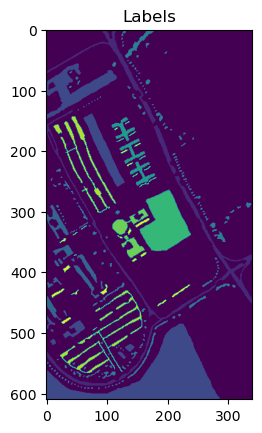

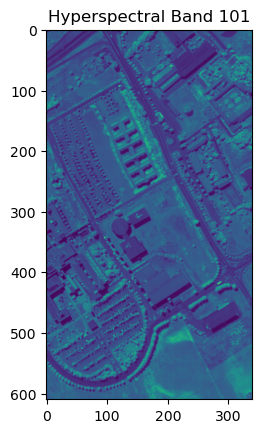

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 10 train


All datasets saved to the 'indices' folder.
(90, 5, 5, 103)
(45, 5, 5, 103)
(42641, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1247, PSNR: 7.2447


	 Training Batch [200/535], Loss: 0.0624, PSNR: 10.1454


	 Training Batch [400/535], Loss: 0.0322, PSNR: 14.9218


Epoch [1/50] Training Loss: 0.0566, PSNR: 11.0761
	[Val]   Batch [1/134] Loss: 0.0196, PSNR: 15.2805
	[Val]   Batch [10/134] Loss: 0.0172, PSNR: 17.6374
	[Val]   Batch [20/134] Loss: 0.0185, PSNR: 15.4394
	[Val]   Batch [30/134] Loss: 0.0200, PSNR: 14.9087
	[Val]   Batch [40/134] Loss: 0.0182, PSNR: 13.9462
	[Val]   Batch [50/134] Loss: 0.0194, PSNR: 15.1027


	[Val]   Batch [60/134] Loss: 0.0176, PSNR: 15.7566
	[Val]   Batch [70/134] Loss: 0.0167, PSNR: 15.9412
	[Val]   Batch [80/134] Loss: 0.0163, PSNR: 15.9403
	[Val]   Batch [90/134] Loss: 0.0171, PSNR: 15.9354
	[Val]   Batch [100/134] Loss: 0.0194, PSNR: 15.3402
	[Val]   Batch [110/134] Loss: 0.0197, PSNR: 13.8658
	[Val]   Batch [120/134] Loss: 0.0161, PSNR: 15.0248


	[Val]   Batch [130/134] Loss: 0.0178, PSNR: 13.0446
Epoch [1/50] Validation Loss: 0.0185, PSNR: 15.3007

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0200, PSNR: 16.6778


	 Training Batch [200/535], Loss: 0.0115, PSNR: 17.5715


	 Training Batch [400/535], Loss: 0.0091, PSNR: 18.5858


Epoch [2/50] Training Loss: 0.0119, PSNR: 17.3189
	[Val]   Batch [1/134] Loss: 0.0088, PSNR: 18.7526
	[Val]   Batch [10/134] Loss: 0.0071, PSNR: 21.5020
	[Val]   Batch [20/134] Loss: 0.0076, PSNR: 19.2770
	[Val]   Batch [30/134] Loss: 0.0087, PSNR: 18.5548
	[Val]   Batch [40/134] Loss: 0.0078, PSNR: 17.6198
	[Val]   Batch [50/134] Loss: 0.0081, PSNR: 18.8833
	[Val]   Batch [60/134] Loss: 0.0070, PSNR: 19.7204


	[Val]   Batch [70/134] Loss: 0.0069, PSNR: 19.7919
	[Val]   Batch [80/134] Loss: 0.0066, PSNR: 19.8861
	[Val]   Batch [90/134] Loss: 0.0070, PSNR: 19.8176
	[Val]   Batch [100/134] Loss: 0.0084, PSNR: 18.9762
	[Val]   Batch [110/134] Loss: 0.0079, PSNR: 17.8345
	[Val]   Batch [120/134] Loss: 0.0059, PSNR: 19.4007
	[Val]   Batch [130/134] Loss: 0.0071, PSNR: 17.0232
Epoch [2/50] Validation Loss: 0.0079, PSNR: 19.0081

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0084, PSNR: 18.8781


	 Training Batch [200/535], Loss: 0.0071, PSNR: 19.5622


	 Training Batch [400/535], Loss: 0.0066, PSNR: 19.9856


Epoch [3/50] Training Loss: 0.0068, PSNR: 19.7049
	[Val]   Batch [1/134] Loss: 0.0060, PSNR: 20.3957
	[Val]   Batch [10/134] Loss: 0.0047, PSNR: 23.2562
	[Val]   Batch [20/134] Loss: 0.0050, PSNR: 21.0928
	[Val]   Batch [30/134] Loss: 0.0058, PSNR: 20.3225
	[Val]   Batch [40/134] Loss: 0.0052, PSNR: 19.3655
	[Val]   Batch [50/134] Loss: 0.0053, PSNR: 20.7268
	[Val]   Batch [60/134] Loss: 0.0046, PSNR: 21.5816


	[Val]   Batch [70/134] Loss: 0.0046, PSNR: 21.5720
	[Val]   Batch [80/134] Loss: 0.0043, PSNR: 21.7084
	[Val]   Batch [90/134] Loss: 0.0046, PSNR: 21.6048
	[Val]   Batch [100/134] Loss: 0.0056, PSNR: 20.7130
	[Val]   Batch [110/134] Loss: 0.0050, PSNR: 19.7925
	[Val]   Batch [120/134] Loss: 0.0036, PSNR: 21.5527
	[Val]   Batch [130/134] Loss: 0.0046, PSNR: 18.9662
Epoch [3/50] Validation Loss: 0.0053, PSNR: 20.7464

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0050, PSNR: 21.2256


	 Training Batch [200/535], Loss: 0.0039, PSNR: 22.2156


	 Training Batch [400/535], Loss: 0.0044, PSNR: 21.8209


Epoch [4/50] Training Loss: 0.0048, PSNR: 21.1623
	[Val]   Batch [1/134] Loss: 0.0042, PSNR: 21.9414
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.7153
	[Val]   Batch [20/134] Loss: 0.0034, PSNR: 22.8121
	[Val]   Batch [30/134] Loss: 0.0039, PSNR: 22.0595
	[Val]   Batch [40/134] Loss: 0.0035, PSNR: 21.0874
	[Val]   Batch [50/134] Loss: 0.0035, PSNR: 22.5825
	[Val]   Batch [60/134] Loss: 0.0033, PSNR: 22.9966


	[Val]   Batch [70/134] Loss: 0.0033, PSNR: 23.0468
	[Val]   Batch [80/134] Loss: 0.0031, PSNR: 23.1772
	[Val]   Batch [90/134] Loss: 0.0033, PSNR: 23.1260
	[Val]   Batch [100/134] Loss: 0.0039, PSNR: 22.3021
	[Val]   Batch [110/134] Loss: 0.0033, PSNR: 21.6750
	[Val]   Batch [120/134] Loss: 0.0024, PSNR: 23.2809
	[Val]   Batch [130/134] Loss: 0.0030, PSNR: 20.7953
Epoch [4/50] Validation Loss: 0.0037, PSNR: 22.3210

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0046, PSNR: 23.3351


	 Training Batch [200/535], Loss: 0.0035, PSNR: 22.5804


	 Training Batch [400/535], Loss: 0.0030, PSNR: 23.3463


Epoch [5/50] Training Loss: 0.0035, PSNR: 22.5129
	[Val]   Batch [1/134] Loss: 0.0032, PSNR: 23.1564
	[Val]   Batch [10/134] Loss: 0.0025, PSNR: 25.9586
	[Val]   Batch [20/134] Loss: 0.0024, PSNR: 24.2790
	[Val]   Batch [30/134] Loss: 0.0028, PSNR: 23.5069
	[Val]   Batch [40/134] Loss: 0.0025, PSNR: 22.5717
	[Val]   Batch [50/134] Loss: 0.0024, PSNR: 24.1411


	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.0868
	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.2476
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.3677
	[Val]   Batch [90/134] Loss: 0.0025, PSNR: 24.2924
	[Val]   Batch [100/134] Loss: 0.0029, PSNR: 23.6315
	[Val]   Batch [110/134] Loss: 0.0022, PSNR: 23.3893
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.7310
	[Val]   Batch [130/134] Loss: 0.0021, PSNR: 22.2412
Epoch [5/50] Validation Loss: 0.0028, PSNR: 23.6170

LOG: Epoch [6/50]


	 Training Batch [1/535], Loss: 0.0040, PSNR: 22.1552


	 Training Batch [200/535], Loss: 0.0029, PSNR: 23.7957


	 Training Batch [400/535], Loss: 0.0028, PSNR: 23.6455


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.4249
	[Val]   Batch [1/134] Loss: 0.0027, PSNR: 23.8895
	[Val]   Batch [10/134] Loss: 0.0021, PSNR: 26.7427
	[Val]   Batch [20/134] Loss: 0.0020, PSNR: 25.1727
	[Val]   Batch [30/134] Loss: 0.0023, PSNR: 24.3936
	[Val]   Batch [40/134] Loss: 0.0020, PSNR: 23.4771
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.1048
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.7756


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 25.0025
	[Val]   Batch [80/134] Loss: 0.0020, PSNR: 25.1355
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 25.0226
	[Val]   Batch [100/134] Loss: 0.0024, PSNR: 24.4712
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.4213
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.7038
	[Val]   Batch [130/134] Loss: 0.0018, PSNR: 23.1139
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.4189

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 23.2038


	 Training Batch [200/535], Loss: 0.0027, PSNR: 22.9687


	 Training Batch [400/535], Loss: 0.0015, PSNR: 25.4074


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.0803
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.5075
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.3916
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.0393
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.1708
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.2724
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.9075
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.3874


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6331
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.8256
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.6307
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.1571
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.3267
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5363
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.8624
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.1232

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 23.8887


	 Training Batch [200/535], Loss: 0.0019, PSNR: 23.7284


	 Training Batch [400/535], Loss: 0.0019, PSNR: 22.9127


Epoch [8/50] Training Loss: 0.0023, PSNR: 24.5081
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 24.9175
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.8022
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.6309
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.6980
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.8470
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4184
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.7817


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0387
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.2772
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 26.0208
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.6164
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9302
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0647
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.3567
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.5972

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 24.8934


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.7329


	 Training Batch [400/535], Loss: 0.0027, PSNR: 23.8005


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.8457
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.2201
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1525
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.1149
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.0967
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.3071
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.8148
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.1296


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.3881
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.6677
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.3582
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 26.0032
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.4231
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5557
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.7829
Epoch [9/50] Validation Loss: 0.0016, PSNR: 25.9855

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.6571


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.7709


	 Training Batch [400/535], Loss: 0.0014, PSNR: 24.7871


Epoch [10/50] Training Loss: 0.0020, PSNR: 25.1268
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4941
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4255
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4759
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.4330
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6801
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1618
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.4156


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6578
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9839
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.6444
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.3037
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.8008
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.9107
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.1174
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.3053

LOG: Epoch [11/50]


	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.4210


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.2114


	 Training Batch [400/535], Loss: 0.0031, PSNR: 23.4295


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.3789
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6912
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6384
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7820
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.6816
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 25.9581
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4042
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6294


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.8474
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2425
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8699
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5226
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.0903
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.1787
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.3685
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.5519

LOG: Epoch [12/50]


	 Training Batch [1/535], Loss: 0.0022, PSNR: 24.9867


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.6262


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.1494


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.5617
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9158
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8938
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1220
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0053
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.3073
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.7230
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9224


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1200
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5262
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1230
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.8204
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.4775
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.5431
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.6947
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.8466

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.3715


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.2068


	 Training Batch [400/535], Loss: 0.0028, PSNR: 23.7024


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.7603
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0230
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 29.0072
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.2467
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0994
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4108
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.8045


	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.0303
	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.2380
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6614
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2559
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9342
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5654
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6452


	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.7865
Epoch [13/50] Validation Loss: 0.0013, PSNR: 26.9611

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.1954


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.6333


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.5524


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.8691
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.2757
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2530
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6323
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4392
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.7941
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1573
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3295


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4900
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9567
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5282
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.2145
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9686
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0044
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1715
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.2821

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.5390


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.5312


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9219


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.0665
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3613
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3297
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.7380
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.5194
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8915
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2213


	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4294
	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.5961
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0605
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.6336
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.2997
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 28.0043
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0588


	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.2464
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.3713

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.1125


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.8476


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.8373


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2619
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6129
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5753
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.1235
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8202
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.2310
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5410
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.7262


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8648
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3695
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9127
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5820
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3634
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3988
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5978
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6736

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 25.9520


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.9944


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.1338


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4060
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.7633
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7084
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.3452
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0116
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4290
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7319


	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.9325
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0470
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5455
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.0846
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7611
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5699
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5807


	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7859
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.8530

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.2188


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6572


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4550


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.5205
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8584
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7844
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4494
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0763
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4904
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7386
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0607


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1915
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6693
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1956
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8351
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5127
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5822
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8327
Epoch [18/50] Validation Loss: 0.0011, PSNR: 27.9375

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.8877


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.0333


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.7493


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.6840
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.1239
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9712
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.8380
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4144
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8606
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0977
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.3782


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5095
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9412
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4825
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.1620
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8308
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8106
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1885
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.2440

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6895


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.7656


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.3197


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.9060
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3581
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1772
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.1955
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.7363
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.1831
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4086
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.7305


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.8413
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2055
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.7859
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.4806
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0645
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0305
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.4841
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.5256

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8166


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.4448


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.1936


Epoch [21/50] Training Loss: 0.0013, PSNR: 27.0403
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.6568
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3899
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.5079
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.0830
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4355
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.6917


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.0553
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1699
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.4978
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.1239
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7944
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2465
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1742


	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7020
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.8004

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 28.1930


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.4873


	 Training Batch [400/535], Loss: 0.0011, PSNR: 29.4421


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.2540
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.8975
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.5644
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7103
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.3322
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6203
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.8774


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.3441
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.4805
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7101
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.4232
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.0837
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2939
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2555


	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.9056
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.0254

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.1371


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.3191


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4463


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.4970
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2695
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8258
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.0151
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.7487
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9409
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.2736


	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6783
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.8524
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0291
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7932
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.4533
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.5014
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4342


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.1698
Epoch [23/50] Validation Loss: 0.0008, PSNR: 29.3555

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.3693


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.6298


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.9231


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.6767
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.5611
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.0824
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.2973
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.0929
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2034
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.5455


	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9403
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.1879
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2664
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.1192
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.7767
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7052
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6069


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4096
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.6443

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.9085


	 Training Batch [200/535], Loss: 0.0013, PSNR: 26.9881


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.3518


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.8515
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9143
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3801
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6085
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4799
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4394
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.9192


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2560
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.5254
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5375
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4692
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1448
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9176
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7898


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6585
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.9642

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.2098


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.9547


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.4962


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0424
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.1720
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.5580
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7527
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.7173
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6137
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.1082
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4476


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7541
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.6804
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.7054
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3606
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9938
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8597
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8089
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.1654

LOG: Epoch [27/50]


	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.1172


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.0049


	 Training Batch [400/535], Loss: 0.0009, PSNR: 26.5555


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.1611
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3729
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6343
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.8270
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.8666
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6568
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.2048
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5009


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.8554
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.7517
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8656
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.5257
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.0335
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8345
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8680
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.2875

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.6167


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.7406


	 Training Batch [400/535], Loss: 0.0008, PSNR: 29.3039


Epoch [28/50] Training Loss: 0.0009, PSNR: 28.2948
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.7112
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.9549
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1706
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.2539
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9270
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.5877
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7681


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1630
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0434
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.1897
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.8655
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3107
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.1247
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1035
Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.6166
Early stopping triggered at epoch 28. No improvement for 3 epochs.


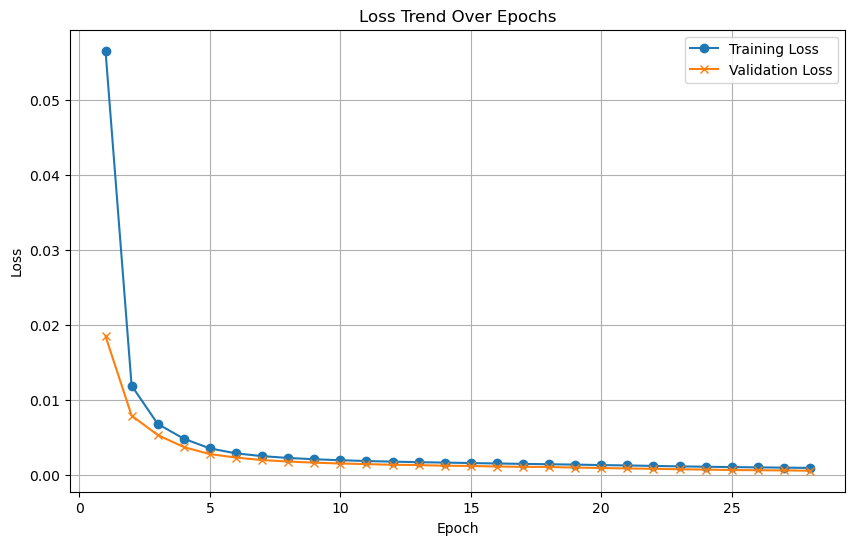

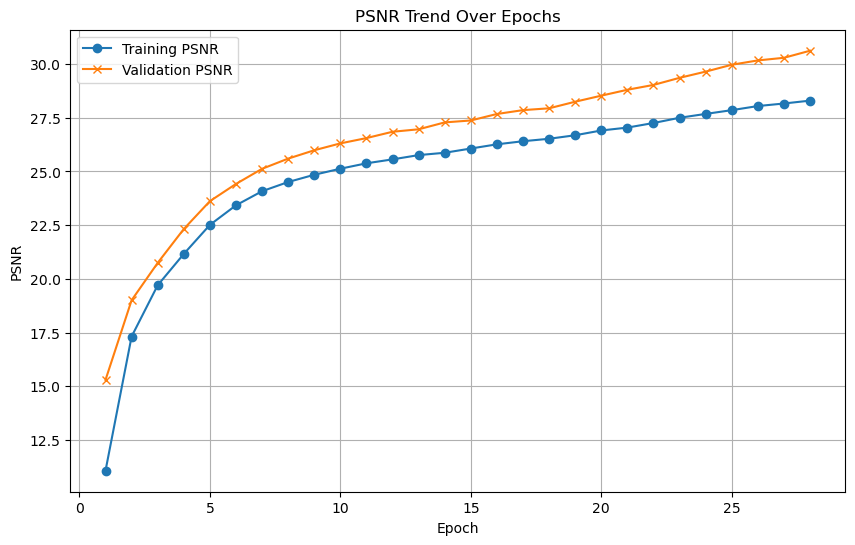

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2101
    Validation Batch [1/1], Loss: 2.2036
Validation Loss: 2.2036, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2036. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1636
    Validation Batch [1/1], Loss: 2.2036
Validation Loss: 2.2036, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1312
    Validation Batch [1/1], Loss: 2.2036
Validation Loss: 2.2036, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0924
    Validation Batch [1/1], Loss: 2.2037
Validation Loss: 2.2037, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag


LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.8059
    Validation Batch [1/1], Loss: 2.2000
Validation Loss: 2.2000, Validation Accuracy: 11.11%
Validation loss improved from 2.2011 to 2.2000. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.7708
    Validation Batch [1/1], Loss: 2.1986
Validation Loss: 2.1986, Validation Accuracy: 11.11%
Validation loss improved from 2.2000 to 2.1986. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.7620
    Validation Batch [1/1], Loss: 2.1965
Validation Loss: 2.1965, Validation Accuracy: 11.11%
Validation loss improved from 2.1986 to 2.1965. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 1.7718
    Validation Batch [1/1], Loss: 2.1937
Validation Loss: 2.1937, Validation Accuracy: 11.11%
Validation loss improved from 2.1965 to 2.1937. Saving model...

LOG: Ep

    Validation Batch [1/1], Loss: 1.7026
Validation Loss: 1.7026, Validation Accuracy: 57.78%
Validation loss improved from 1.7169 to 1.7026. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.5615
    Validation Batch [1/1], Loss: 1.6886
Validation Loss: 1.6886, Validation Accuracy: 57.78%
Validation loss improved from 1.7026 to 1.6886. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.5255
    Validation Batch [1/1], Loss: 1.6755
Validation Loss: 1.6755, Validation Accuracy: 60.00%
Validation loss improved from 1.6886 to 1.6755. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.5283
    Validation Batch [1/1], Loss: 1.6620
Validation Loss: 1.6620, Validation Accuracy: 62.22%
Validation loss improved from 1.6755 to 1.6620. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.4904
    Vali

    Validation Batch [1/1], Loss: 1.4112
Validation Loss: 1.4112, Validation Accuracy: 71.11%
Validation loss improved from 1.4198 to 1.4112. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.3347
    Validation Batch [1/1], Loss: 1.4019
Validation Loss: 1.4019, Validation Accuracy: 68.89%
Validation loss improved from 1.4112 to 1.4019. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.2974
    Validation Batch [1/1], Loss: 1.3952
Validation Loss: 1.3952, Validation Accuracy: 68.89%
Validation loss improved from 1.4019 to 1.3952. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.3242
    Validation Batch [1/1], Loss: 1.3899
Validation Loss: 1.3899, Validation Accuracy: 68.89%
Validation loss improved from 1.3952 to 1.3899. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.3110
    Vali

Epoch [116/1000] completed, Average Training Loss: 1.1034
    Validation Batch [1/1], Loss: 1.2314
Validation Loss: 1.2314, Validation Accuracy: 68.89%
Validation loss improved from 1.2347 to 1.2314. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.0502
    Validation Batch [1/1], Loss: 1.2300
Validation Loss: 1.2300, Validation Accuracy: 71.11%
Validation loss improved from 1.2314 to 1.2300. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.0639
    Validation Batch [1/1], Loss: 1.2265
Validation Loss: 1.2265, Validation Accuracy: 73.33%
Validation loss improved from 1.2300 to 1.2265. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.0789
    Validation Batch [1/1], Loss: 1.2189
Validation Loss: 1.2189, Validation Accuracy: 71.11%
Validation loss improved from 1.2265 to 1.2189. Saving model...

LOG: Epoch [120/1000] - Training


Epoch [146/1000] completed, Average Training Loss: 0.8595
    Validation Batch [1/1], Loss: 1.0693
Validation Loss: 1.0693, Validation Accuracy: 75.56%
Validation loss improved from 1.0703 to 1.0693. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.8522
    Validation Batch [1/1], Loss: 1.0669
Validation Loss: 1.0669, Validation Accuracy: 82.22%
Validation loss improved from 1.0693 to 1.0669. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.8587
    Validation Batch [1/1], Loss: 1.0582
Validation Loss: 1.0582, Validation Accuracy: 82.22%
Validation loss improved from 1.0669 to 1.0582. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.8275
    Validation Batch [1/1], Loss: 1.0400
Validation Loss: 1.0400, Validation Accuracy: 80.00%
Validation loss improved from 1.0582 to 1.0400. Saving model...

LOG: Epoch [150/1000] - Training


Epoch [178/1000] completed, Average Training Loss: 0.6321
    Validation Batch [1/1], Loss: 0.9006
Validation Loss: 0.9006, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.6487
    Validation Batch [1/1], Loss: 0.9002
Validation Loss: 0.9002, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.6577
    Validation Batch [1/1], Loss: 0.8808
Validation Loss: 0.8808, Validation Accuracy: 82.22%
Validation loss improved from 0.8953 to 0.8808. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 0.6100
    Validation Batch [1/1], Loss: 0.8770
Validation Loss: 0.8770, Validation Accuracy: 75.56%
Validation loss improved from 0.8808 to 0.8770. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Av

Epoch [211/1000] completed, Average Training Loss: 0.4383
    Validation Batch [1/1], Loss: 0.7565
Validation Loss: 0.7565, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.4274
    Validation Batch [1/1], Loss: 0.7490
Validation Loss: 0.7490, Validation Accuracy: 82.22%
Validation loss improved from 0.7497 to 0.7490. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.4731
    Validation Batch [1/1], Loss: 0.7360
Validation Loss: 0.7360, Validation Accuracy: 86.67%
Validation loss improved from 0.7490 to 0.7360. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.4386
    Validation Batch [1/1], Loss: 0.7300
Validation Loss: 0.7300, Validation Accuracy: 86.67%
Validation loss improved from 0.7360 to 0.7300. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000

    Validation Batch [1/1], Loss: 0.6260
Validation Loss: 0.6260, Validation Accuracy: 88.89%
Validation loss improved from 0.6438 to 0.6260. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.2959
    Validation Batch [1/1], Loss: 0.6252
Validation Loss: 0.6252, Validation Accuracy: 88.89%
Validation loss improved from 0.6260 to 0.6252. Saving model...

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.2956
    Validation Batch [1/1], Loss: 0.6301
Validation Loss: 0.6301, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.3005
    Validation Batch [1/1], Loss: 0.6345
Validation Loss: 0.6345, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.3300
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.5805
Validation Loss: 0.5805, Validation Accuracy: 86.67%
Validation loss improved from 0.5826 to 0.5805. Saving model...

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.2372
    Validation Batch [1/1], Loss: 0.5682
Validation Loss: 0.5682, Validation Accuracy: 86.67%
Validation loss improved from 0.5805 to 0.5682. Saving model...

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.2322
    Validation Batch [1/1], Loss: 0.5634
Validation Loss: 0.5634, Validation Accuracy: 88.89%
Validation loss improved from 0.5682 to 0.5634. Saving model...

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.2261
    Validation Batch [1/1], Loss: 0.5765
Validation Loss: 0.5765, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.2417
    Validation 

Epoch [304/1000] completed, Average Training Loss: 0.1774
    Validation Batch [1/1], Loss: 0.5256
Validation Loss: 0.5256, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.2022
    Validation Batch [1/1], Loss: 0.5501
Validation Loss: 0.5501, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.1793
    Validation Batch [1/1], Loss: 0.5707
Validation Loss: 0.5707, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.1739
    Validation Batch [1/1], Loss: 0.5652
Validation Loss: 0.5652, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.159

    Validation Batch [1/1], Loss: 0.5037
Validation Loss: 0.5037, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.1433
    Validation Batch [1/1], Loss: 0.5000
Validation Loss: 0.5000, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.1379
    Validation Batch [1/1], Loss: 0.4924
Validation Loss: 0.4924, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.1281
    Validation Batch [1/1], Loss: 0.4937
Validation Loss: 0.4937, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.1345
    Validation Batch [1/1], Loss: 0.4972
Validation Loss

Epoch [366/1000] completed, Average Training Loss: 0.0981
    Validation Batch [1/1], Loss: 0.4824
Validation Loss: 0.4824, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.1184
    Validation Batch [1/1], Loss: 0.4794
Validation Loss: 0.4794, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.1262
    Validation Batch [1/1], Loss: 0.4674
Validation Loss: 0.4674, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.1024
    Validation Batch [1/1], Loss: 0.4539
Validation Loss: 0.4539, Validation Accuracy: 86.67%
Validation loss improved from 0.4553 to 0.4539. Saving model...

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Traini

    Validation Batch [1/1], Loss: 0.4490
Validation Loss: 0.4490, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0933
    Validation Batch [1/1], Loss: 0.4544
Validation Loss: 0.4544, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0914
    Validation Batch [1/1], Loss: 0.4583
Validation Loss: 0.4583, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0742
    Validation Batch [1/1], Loss: 0.4621
Validation Loss: 0.4621, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0847
    Validation Batch [1/1], Loss: 0.4607
Validation Loss

Epoch [430/1000] completed, Average Training Loss: 0.0851
    Validation Batch [1/1], Loss: 0.4454
Validation Loss: 0.4454, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.0620
    Validation Batch [1/1], Loss: 0.4436
Validation Loss: 0.4436, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.0622
    Validation Batch [1/1], Loss: 0.4491
Validation Loss: 0.4491, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0926
    Validation Batch [1/1], Loss: 0.4573
Validation Loss: 0.4573, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.067

Epoch [464/1000] completed, Average Training Loss: 0.0493
    Validation Batch [1/1], Loss: 0.3993
Validation Loss: 0.3993, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0799
    Validation Batch [1/1], Loss: 0.4041
Validation Loss: 0.4041, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0565
    Validation Batch [1/1], Loss: 0.4310
Validation Loss: 0.4310, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0530
    Validation Batch [1/1], Loss: 0.4405
Validation Loss: 0.4405, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0558
  

Epoch [497/1000] completed, Average Training Loss: 0.0566
    Validation Batch [1/1], Loss: 0.4018
Validation Loss: 0.4018, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0503
    Validation Batch [1/1], Loss: 0.4191
Validation Loss: 0.4191, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0456
    Validation Batch [1/1], Loss: 0.4330
Validation Loss: 0.4330, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0481
    Validation Batch [1/1], Loss: 0.4523
Validation Loss: 0.4523, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0557
  

Epoch [526/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.4266
Validation Loss: 0.4266, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0343
    Validation Batch [1/1], Loss: 0.4140
Validation Loss: 0.4140, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.4161
Validation Loss: 0.4161, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.4267
Validation Loss: 0.4267, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.048

Epoch [555/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.4711
Validation Loss: 0.4711, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.4197
Validation Loss: 0.4197, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0345
    Validation Batch [1/1], Loss: 0.3990
Validation Loss: 0.3990, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0447
    Validation Batch [1/1], Loss: 0.3930
Validation Loss: 0.3930, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.035

Epoch [584/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.4398
Validation Loss: 0.4398, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0369
    Validation Batch [1/1], Loss: 0.4141
Validation Loss: 0.4141, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0289
    Validation Batch [1/1], Loss: 0.3945
Validation Loss: 0.3945, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.3858
Validation Loss: 0.3858, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.030

Epoch [617/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.3888
Validation Loss: 0.3888, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0331
    Validation Batch [1/1], Loss: 0.4024
Validation Loss: 0.4024, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0337
    Validation Batch [1/1], Loss: 0.4230
Validation Loss: 0.4230, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.4527
Validation Loss: 0.4527, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.027

Epoch [651/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.4576
Validation Loss: 0.4576, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.4529
Validation Loss: 0.4529, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [653/1000] - Training
Epoch [653/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.4424
Validation Loss: 0.4424, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [654/1000] - Training
Epoch [654/1000] completed, Average Training Loss: 0.0304
    Validation Batch [1/1], Loss: 0.4241
Validation Loss: 0.4241, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [655/1000] - Training
Epoch [655/1000] completed, Average Training Loss: 0.027

Epoch [684/1000] completed, Average Training Loss: 0.0226
    Validation Batch [1/1], Loss: 0.3995
Validation Loss: 0.3995, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.4072
Validation Loss: 0.4072, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.0315
    Validation Batch [1/1], Loss: 0.4320
Validation Loss: 0.4320, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.4489
Validation Loss: 0.4489, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.023

    Validation Batch [1/1], Loss: 0.4312
Validation Loss: 0.4312, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0173
    Validation Batch [1/1], Loss: 0.4420
Validation Loss: 0.4420, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [719/1000] - Training
Epoch [719/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.4310
Validation Loss: 0.4310, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.4262
Validation Loss: 0.4262, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.0295
    Validation Batch [1/1], Loss: 0.4188
Validation Loss

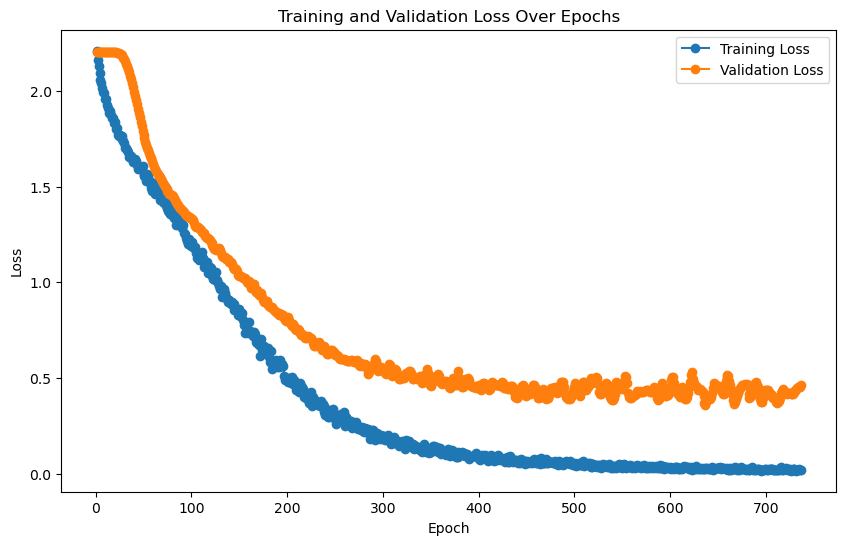

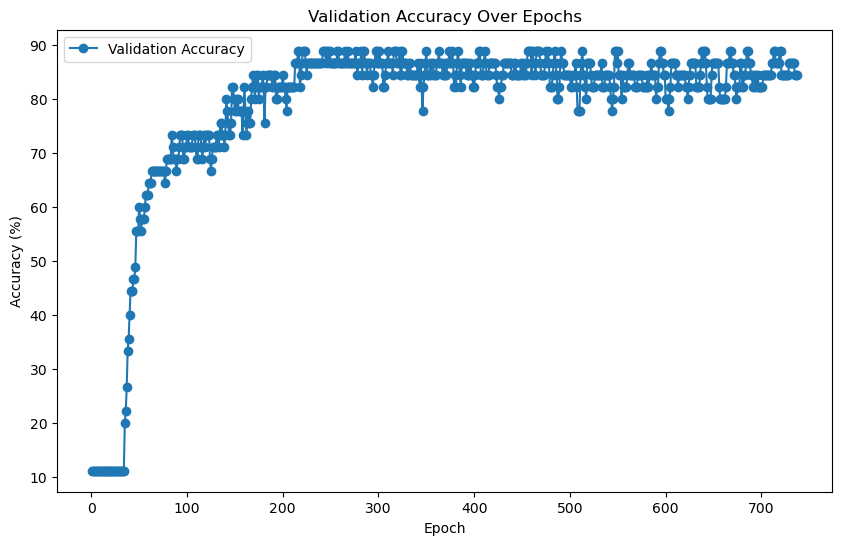


Evaluating on the test set...
    Test Batch [1/167], Loss: 1.7364



Final Test Loss: 0.8179, Test Accuracy: 74.62%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.


  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42641, 64), Test labels shape: (42641,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      0.80      0.73         5
           2       0.50      0.60      0.55         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       0.45      1.00      0.62         5
           7       1.00      0.40      0.57         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42641, 64)
Test labels shape: (42641,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.2468  |  Val Loss: 2.8569
Validation loss improved from inf to 2.8569.
[Epoch 2/1000] Train Loss: 2.8051  |  Val Loss: 2.4805
Validation loss improved from 2.8569 to 2.4805.
[Epoch 3/1000] Train Loss: 2.4640  |  Val Loss: 2.2411
Validation loss improved from 2.4805 to 2.2411.
[Epoch 4/1000] Train Loss: 2.2500  |  Val Loss: 2.1379
Validation loss improved from 2.2411 to 2.1379.
[Epoch 5/1000] Train Loss: 2.1610  |  Val Loss: 2.1013
Validation loss improved from 2.1379 to 2.1013.
[Epoch 6/1000] Train Loss: 2.1155  |  Val Loss: 2.0637
Validation loss improved from 2.1013 to 2.0637.
[Epoch 7/1000] Train Loss: 2.0692  |  Val Loss: 2.0213
Validation loss improved from 2.0637 to 2.0213.
[Epoch 8/1000] Train Loss: 2.0273  |  Val Loss: 1.9707
Validation loss improved from 2.0213 to 1.9707.


[Epoch 9/1000] Train Loss: 1.9760  |  Val Loss: 1.9261
Validation loss improved from 1.9707 to 1.9261.
[Epoch 10/1000] Train Loss: 1.9413  |  Val Loss: 1.8934
Validation loss improved from 1.9261 to 1.8934.
[Epoch 11/1000] Train Loss: 1.9063  |  Val Loss: 1.8571
Validation loss improved from 1.8934 to 1.8571.
[Epoch 12/1000] Train Loss: 1.8717  |  Val Loss: 1.8153
Validation loss improved from 1.8571 to 1.8153.
[Epoch 13/1000] Train Loss: 1.8287  |  Val Loss: 1.7680
Validation loss improved from 1.8153 to 1.7680.
[Epoch 14/1000] Train Loss: 1.7754  |  Val Loss: 1.7169
Validation loss improved from 1.7680 to 1.7169.
[Epoch 15/1000] Train Loss: 1.7192  |  Val Loss: 1.6579
Validation loss improved from 1.7169 to 1.6579.
[Epoch 16/1000] Train Loss: 1.6619  |  Val Loss: 1.6073
Validation loss improved from 1.6579 to 1.6073.
[Epoch 17/1000] Train Loss: 1.6087  |  Val Loss: 1.5645
Validation loss improved from 1.6073 to 1.5645.
[Epoch 18/1000] Train Loss: 1.5514  |  Val Loss: 1.5224
Validatio

[Epoch 31/1000] Train Loss: 0.9706  |  Val Loss: 1.0454
Validation loss improved from 1.0733 to 1.0454.
[Epoch 32/1000] Train Loss: 0.9366  |  Val Loss: 1.0173
Validation loss improved from 1.0454 to 1.0173.
[Epoch 33/1000] Train Loss: 0.9016  |  Val Loss: 0.9953
Validation loss improved from 1.0173 to 0.9953.
[Epoch 34/1000] Train Loss: 0.8772  |  Val Loss: 0.9738
Validation loss improved from 0.9953 to 0.9738.
[Epoch 35/1000] Train Loss: 0.8512  |  Val Loss: 0.9537
Validation loss improved from 0.9738 to 0.9537.
[Epoch 36/1000] Train Loss: 0.8254  |  Val Loss: 0.9319
Validation loss improved from 0.9537 to 0.9319.
[Epoch 37/1000] Train Loss: 0.8009  |  Val Loss: 0.9014
Validation loss improved from 0.9319 to 0.9014.
[Epoch 38/1000] Train Loss: 0.7717  |  Val Loss: 0.8800
Validation loss improved from 0.9014 to 0.8800.
[Epoch 39/1000] Train Loss: 0.7462  |  Val Loss: 0.8690
Validation loss improved from 0.8800 to 0.8690.
[Epoch 40/1000] Train Loss: 0.7322  |  Val Loss: 0.8585
Validati

[Epoch 48/1000] Train Loss: 0.5992  |  Val Loss: 0.7842
Validation loss improved from 0.7915 to 0.7842.
[Epoch 49/1000] Train Loss: 0.5921  |  Val Loss: 0.7819
Validation loss improved from 0.7842 to 0.7819.
[Epoch 50/1000] Train Loss: 0.5816  |  Val Loss: 0.7649
Validation loss improved from 0.7819 to 0.7649.
[Epoch 51/1000] Train Loss: 0.5655  |  Val Loss: 0.7449
Validation loss improved from 0.7649 to 0.7449.
[Epoch 52/1000] Train Loss: 0.5558  |  Val Loss: 0.7356
Validation loss improved from 0.7449 to 0.7356.
[Epoch 53/1000] Train Loss: 0.5526  |  Val Loss: 0.7294
Validation loss improved from 0.7356 to 0.7294.
[Epoch 54/1000] Train Loss: 0.5449  |  Val Loss: 0.7240
Validation loss improved from 0.7294 to 0.7240.
[Epoch 55/1000] Train Loss: 0.5315  |  Val Loss: 0.7294
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 0.5179  |  Val Loss: 0.7494
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 57/1000] Train Loss: 0.5229  |  Val Loss: 0.7681
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 58/1000] Train Loss: 0.5126  |  Val Loss: 0.7527
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 59/1000] Train Loss: 0.5017  |  Val Loss: 0.7403
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 60/1000] Train Loss: 0.4925  |  Val Loss: 0.7301
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 61/1000] Train Loss: 0.4885  |  Val Loss: 0.7244
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 62/1000] Train Loss: 0.4899  |  Val Loss: 0.7234
Validation loss improved from 0.7240 to 0.7234.
[Epoch 63/1000] Train Loss: 0.4793  |  Val Loss: 0.7438
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 0.4694  |  Val Loss: 0.7608
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 65/1000] Train Loss: 0.4677  |  Val Loss: 0.7688
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 66/1000] 

[Epoch 76/1000] Train Loss: 0.4221  |  Val Loss: 0.7806
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 77/1000] Train Loss: 0.4147  |  Val Loss: 0.7839
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 78/1000] Train Loss: 0.4148  |  Val Loss: 0.7777
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 79/1000] Train Loss: 0.4094  |  Val Loss: 0.7672
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 80/1000] Train Loss: 0.4014  |  Val Loss: 0.7597
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 81/1000] Train Loss: 0.3976  |  Val Loss: 0.7702
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 82/1000] Train Loss: 0.3967  |  Val Loss: 0.7836
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 83/1000] Train Loss: 0.3968  |  Val Loss: 0.7852
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 84/1000] Train Loss: 0.3929  |  Val Loss: 0.7847
!! Validation loss did NOT improve !! Patience: 22/100
[

[Epoch 92/1000] Train Loss: 0.3724  |  Val Loss: 0.7893
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 93/1000] Train Loss: 0.3656  |  Val Loss: 0.7934
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 94/1000] Train Loss: 0.3547  |  Val Loss: 0.8026
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 95/1000] Train Loss: 0.3536  |  Val Loss: 0.8116
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 96/1000] Train Loss: 0.3492  |  Val Loss: 0.8195
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 97/1000] Train Loss: 0.3460  |  Val Loss: 0.8349
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 98/1000] Train Loss: 0.3468  |  Val Loss: 0.8380
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 99/1000] Train Loss: 0.3449  |  Val Loss: 0.8254
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 100/1000] Train Loss: 0.3333  |  Val Loss: 0.8131
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 101/1000] Train Loss: 0.3390  |  Val Loss: 0.8208
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 102/1000] Train Loss: 0.3482  |  Val Loss: 0.8209
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 103/1000] Train Loss: 0.3284  |  Val Loss: 0.8594
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 104/1000] Train Loss: 0.3448  |  Val Loss: 0.8866
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 105/1000] Train Loss: 0.3474  |  Val Loss: 0.8684
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 106/1000] Train Loss: 0.3271  |  Val Loss: 0.8494
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 107/1000] Train Loss: 0.3240  |  Val Loss: 0.8566
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 108/1000] Train Loss: 0.3314  |  Val Loss: 0.8669
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 109/1000] Train Loss: 0.3189  |  Val Loss: 0.8785
!! Validation loss did NOT improve !! Patience:

[Epoch 119/1000] Train Loss: 0.2926  |  Val Loss: 0.8911
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 120/1000] Train Loss: 0.2906  |  Val Loss: 0.9248
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 121/1000] Train Loss: 0.2908  |  Val Loss: 0.9360
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 122/1000] Train Loss: 0.2871  |  Val Loss: 0.9114
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 123/1000] Train Loss: 0.2829  |  Val Loss: 0.8960
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 124/1000] Train Loss: 0.2895  |  Val Loss: 0.8971
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 125/1000] Train Loss: 0.2822  |  Val Loss: 0.9208
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 126/1000] Train Loss: 0.2839  |  Val Loss: 0.9625
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 127/1000] Train Loss: 0.2871  |  Val Loss: 0.9522
!! Validation loss did NOT improve !! Patience:

[Epoch 134/1000] Train Loss: 0.2684  |  Val Loss: 0.9461
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 135/1000] Train Loss: 0.2663  |  Val Loss: 0.9809
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 136/1000] Train Loss: 0.2667  |  Val Loss: 1.0083
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 137/1000] Train Loss: 0.2612  |  Val Loss: 1.0027
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 138/1000] Train Loss: 0.2590  |  Val Loss: 0.9808
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 139/1000] Train Loss: 0.2585  |  Val Loss: 0.9537
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 140/1000] Train Loss: 0.2600  |  Val Loss: 0.9544
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 141/1000] Train Loss: 0.2535  |  Val Loss: 0.9827
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 142/1000] Train Loss: 0.2489  |  Val Loss: 0.9943
!! Validation loss did NOT improve !! Patience:

[Epoch 144/1000] Train Loss: 0.2514  |  Val Loss: 0.9803
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 145/1000] Train Loss: 0.2396  |  Val Loss: 0.9973
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 146/1000] Train Loss: 0.2494  |  Val Loss: 1.0097
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 147/1000] Train Loss: 0.2421  |  Val Loss: 1.0000
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 148/1000] Train Loss: 0.2385  |  Val Loss: 1.0125
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 149/1000] Train Loss: 0.2402  |  Val Loss: 1.0030
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 150/1000] Train Loss: 0.2408  |  Val Loss: 1.0080
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 151/1000] Train Loss: 0.2387  |  Val Loss: 1.0040
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 152/1000] Train Loss: 0.2377  |  Val Loss: 1.0343
!! Validation loss did NOT improve !! Patience:

[Epoch 162/1000] Train Loss: 0.2098  |  Val Loss: 1.0586
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 162 !!
No improvement for 100 epochs.


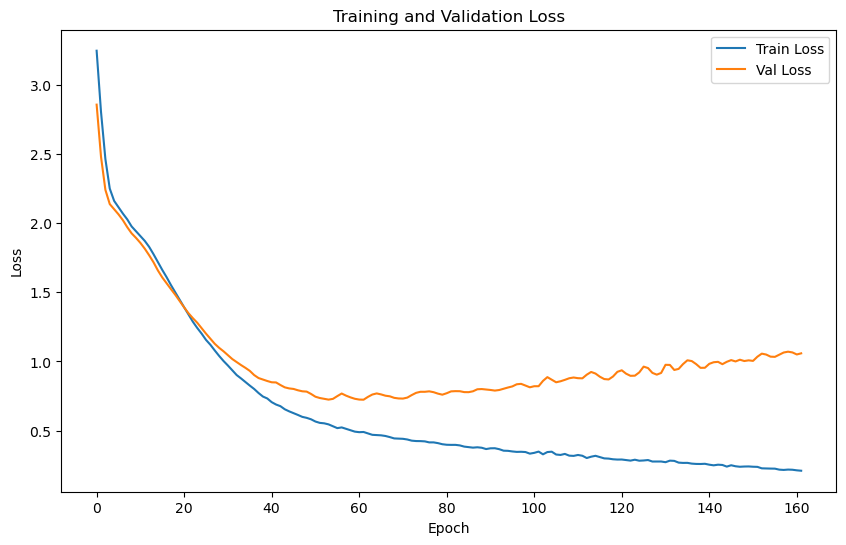

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.9957 | Test Accuracy: 62.94%


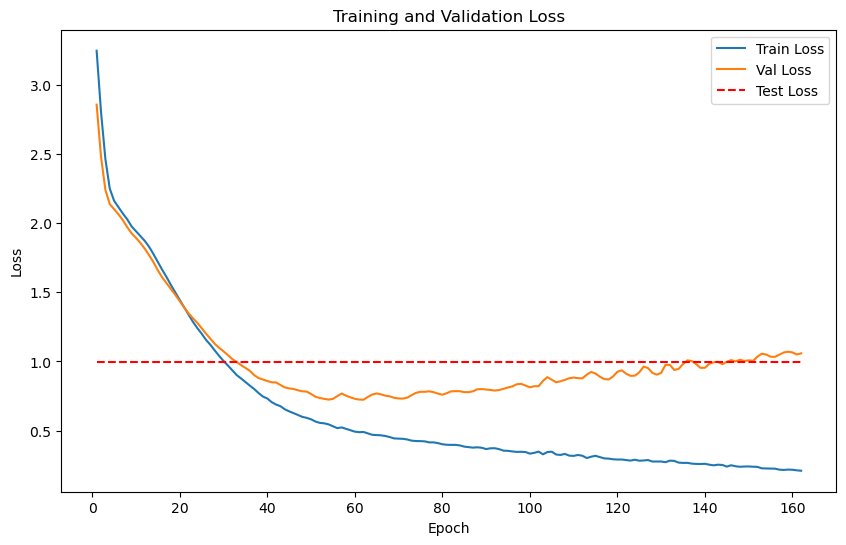

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.4454
Epoch [1/2000], Avg Train Loss: 8.4454


Epoch [1/2000], Avg Val Loss: 4.3184
Validation loss improved from inf to 4.3184. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.2517
Epoch [2/2000], Avg Train Loss: 8.2517
Epoch [2/2000], Avg Val Loss: 4.2818
Validation loss improved from 4.3184 to 4.2818. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.3756
Epoch [3/2000], Avg Train Loss: 8.3756
Epoch [3/2000], Avg Val Loss: 4.2456
Validation loss improved from 4.2818 to 4.2456. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.3810
Epoch [4/2000], Avg Train Loss: 8.3810
Epoch [4/2000], Avg Val Loss: 4.2103
Validation loss improved from 4.2456 to 4.2103. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2152
Epoch [5/2000], Avg Train Loss: 8.2152
Epoch [5/2000], Avg Val Loss: 4.1757
Validation loss improved from 4.2103 to 4.1757. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.2532
Ep

    Batch [1/1], Train Loss: 6.8962
Epoch [22/2000], Avg Train Loss: 6.8962
Epoch [22/2000], Avg Val Loss: 3.6908
Validation loss improved from 3.7141 to 3.6908. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.9632
Epoch [23/2000], Avg Train Loss: 6.9632
Epoch [23/2000], Avg Val Loss: 3.6683
Validation loss improved from 3.6908 to 3.6683. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.7835
Epoch [24/2000], Avg Train Loss: 6.7835
Epoch [24/2000], Avg Val Loss: 3.6464
Validation loss improved from 3.6683 to 3.6464. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7524
Epoch [25/2000], Avg Train Loss: 6.7524
Epoch [25/2000], Avg Val Loss: 3.6251
Validation loss improved from 3.6464 to 3.6251. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.6777
Epoch [26/2000], Avg Train Loss: 6.6777
Epoch [26/2000], Avg Val Loss: 3.6044
Validation loss improved from 3.6251 to 3.

    Batch [1/1], Train Loss: 5.6473
Epoch [47/2000], Avg Train Loss: 5.6473
Epoch [47/2000], Avg Val Loss: 3.2804
Validation loss improved from 3.2917 to 3.2804. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.7122
Epoch [48/2000], Avg Train Loss: 5.7122
Epoch [48/2000], Avg Val Loss: 3.2696
Validation loss improved from 3.2804 to 3.2696. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.7161
Epoch [49/2000], Avg Train Loss: 5.7161
Epoch [49/2000], Avg Val Loss: 3.2592
Validation loss improved from 3.2696 to 3.2592. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.5435
Epoch [50/2000], Avg Train Loss: 5.5435
Epoch [50/2000], Avg Val Loss: 3.2492
Validation loss improved from 3.2592 to 3.2492. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.5966
Epoch [51/2000], Avg Train Loss: 5.5966
Epoch [51/2000], Avg Val Loss: 3.2395
Validation loss improved from 3.2492 to 3.

Epoch [69/2000], Avg Val Loss: 3.1092
Validation loss improved from 3.1149 to 3.1092. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 4.9937
Epoch [70/2000], Avg Train Loss: 4.9937
Epoch [70/2000], Avg Val Loss: 3.1038
Validation loss improved from 3.1092 to 3.1038. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.8253
Epoch [71/2000], Avg Train Loss: 4.8253
Epoch [71/2000], Avg Val Loss: 3.0986
Validation loss improved from 3.1038 to 3.0986. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.8715
Epoch [72/2000], Avg Train Loss: 4.8715
Epoch [72/2000], Avg Val Loss: 3.0935
Validation loss improved from 3.0986 to 3.0935. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.9307
Epoch [73/2000], Avg Train Loss: 4.9307
Epoch [73/2000], Avg Val Loss: 3.0886
Validation loss improved from 3.0935 to 3.0886. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Trai

Epoch [96/2000], Avg Val Loss: 3.0031
Validation loss improved from 3.0059 to 3.0031. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.5493
Epoch [97/2000], Avg Train Loss: 4.5493
Epoch [97/2000], Avg Val Loss: 3.0005
Validation loss improved from 3.0031 to 3.0005. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.5525
Epoch [98/2000], Avg Train Loss: 4.5525
Epoch [98/2000], Avg Val Loss: 2.9979
Validation loss improved from 3.0005 to 2.9979. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.5140
Epoch [99/2000], Avg Train Loss: 4.5140
Epoch [99/2000], Avg Val Loss: 2.9954
Validation loss improved from 2.9979 to 2.9954. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.5945
Epoch [100/2000], Avg Train Loss: 4.5945
Epoch [100/2000], Avg Val Loss: 2.9930
Validation loss improved from 2.9954 to 2.9930. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], 

    Batch [1/1], Train Loss: 4.3740
Epoch [115/2000], Avg Train Loss: 4.3740
Epoch [115/2000], Avg Val Loss: 2.9629
Validation loss improved from 2.9646 to 2.9629. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.3970
Epoch [116/2000], Avg Train Loss: 4.3970
Epoch [116/2000], Avg Val Loss: 2.9612
Validation loss improved from 2.9629 to 2.9612. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.3305
Epoch [117/2000], Avg Train Loss: 4.3305
Epoch [117/2000], Avg Val Loss: 2.9594
Validation loss improved from 2.9612 to 2.9594. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.3653
Epoch [118/2000], Avg Train Loss: 4.3653
Epoch [118/2000], Avg Val Loss: 2.9577
Validation loss improved from 2.9594 to 2.9577. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.3049
Epoch [119/2000], Avg Train Loss: 4.3049
Epoch [119/2000], Avg Val Loss: 2.9559
Validation loss improved fro

Epoch [142/2000], Avg Val Loss: 2.9209
Validation loss improved from 2.9223 to 2.9209. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.1716
Epoch [143/2000], Avg Train Loss: 4.1716
Epoch [143/2000], Avg Val Loss: 2.9195
Validation loss improved from 2.9209 to 2.9195. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.0664
Epoch [144/2000], Avg Train Loss: 4.0664
Epoch [144/2000], Avg Val Loss: 2.9181
Validation loss improved from 2.9195 to 2.9181. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.0442
Epoch [145/2000], Avg Train Loss: 4.0442
Epoch [145/2000], Avg Val Loss: 2.9167
Validation loss improved from 2.9181 to 2.9167. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.1368
Epoch [146/2000], Avg Train Loss: 4.1368
Epoch [146/2000], Avg Val Loss: 2.9153
Validation loss improved from 2.9167 to 2.9153. Saving model...

LOG: Epoch [147/2000] - Training
    Bat

Epoch [159/2000], Avg Val Loss: 2.8977
Validation loss improved from 2.8990 to 2.8977. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.1575
Epoch [160/2000], Avg Train Loss: 4.1575
Epoch [160/2000], Avg Val Loss: 2.8964
Validation loss improved from 2.8977 to 2.8964. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 3.9351
Epoch [161/2000], Avg Train Loss: 3.9351
Epoch [161/2000], Avg Val Loss: 2.8950
Validation loss improved from 2.8964 to 2.8950. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.1053
Epoch [162/2000], Avg Train Loss: 4.1053
Epoch [162/2000], Avg Val Loss: 2.8937
Validation loss improved from 2.8950 to 2.8937. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.0996
Epoch [163/2000], Avg Train Loss: 4.0996
Epoch [163/2000], Avg Val Loss: 2.8923
Validation loss improved from 2.8937 to 2.8923. Saving model...

LOG: Epoch [164/2000] - Training
    Bat

Epoch [184/2000], Avg Val Loss: 2.8645
Validation loss improved from 2.8658 to 2.8645. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 3.9696
Epoch [185/2000], Avg Train Loss: 3.9696
Epoch [185/2000], Avg Val Loss: 2.8631
Validation loss improved from 2.8645 to 2.8631. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 3.9221
Epoch [186/2000], Avg Train Loss: 3.9221
Epoch [186/2000], Avg Val Loss: 2.8618
Validation loss improved from 2.8631 to 2.8618. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 3.9730
Epoch [187/2000], Avg Train Loss: 3.9730
Epoch [187/2000], Avg Val Loss: 2.8605
Validation loss improved from 2.8618 to 2.8605. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 3.9337
Epoch [188/2000], Avg Train Loss: 3.9337
Epoch [188/2000], Avg Val Loss: 2.8592
Validation loss improved from 2.8605 to 2.8592. Saving model...

LOG: Epoch [189/2000] - Training
    Bat

Epoch [201/2000], Avg Val Loss: 2.8423
Validation loss improved from 2.8435 to 2.8423. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 3.8354
Epoch [202/2000], Avg Train Loss: 3.8354
Epoch [202/2000], Avg Val Loss: 2.8411
Validation loss improved from 2.8423 to 2.8411. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 3.8680
Epoch [203/2000], Avg Train Loss: 3.8680
Epoch [203/2000], Avg Val Loss: 2.8398
Validation loss improved from 2.8411 to 2.8398. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 3.9457
Epoch [204/2000], Avg Train Loss: 3.9457
Epoch [204/2000], Avg Val Loss: 2.8386
Validation loss improved from 2.8398 to 2.8386. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 3.7991
Epoch [205/2000], Avg Train Loss: 3.7991
Epoch [205/2000], Avg Val Loss: 2.8373
Validation loss improved from 2.8386 to 2.8373. Saving model...

LOG: Epoch [206/2000] - Training
    Bat

Epoch [230/2000], Avg Val Loss: 2.8077
Validation loss improved from 2.8088 to 2.8077. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 3.8171
Epoch [231/2000], Avg Train Loss: 3.8171
Epoch [231/2000], Avg Val Loss: 2.8066
Validation loss improved from 2.8077 to 2.8066. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 3.8501
Epoch [232/2000], Avg Train Loss: 3.8501
Epoch [232/2000], Avg Val Loss: 2.8055
Validation loss improved from 2.8066 to 2.8055. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 3.7917
Epoch [233/2000], Avg Train Loss: 3.7917
Epoch [233/2000], Avg Val Loss: 2.8044
Validation loss improved from 2.8055 to 2.8044. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 3.7533
Epoch [234/2000], Avg Train Loss: 3.7533
Epoch [234/2000], Avg Val Loss: 2.8032
Validation loss improved from 2.8044 to 2.8032. Saving model...

LOG: Epoch [235/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8062
Epoch [251/2000], Avg Train Loss: 3.8062
Epoch [251/2000], Avg Val Loss: 2.7849
Validation loss improved from 2.7859 to 2.7849. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 3.7553
Epoch [252/2000], Avg Train Loss: 3.7553
Epoch [252/2000], Avg Val Loss: 2.7838
Validation loss improved from 2.7849 to 2.7838. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 3.6479
Epoch [253/2000], Avg Train Loss: 3.6479
Epoch [253/2000], Avg Val Loss: 2.7827
Validation loss improved from 2.7838 to 2.7827. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 3.7441
Epoch [254/2000], Avg Train Loss: 3.7441
Epoch [254/2000], Avg Val Loss: 2.7817
Validation loss improved from 2.7827 to 2.7817. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 3.7411
Epoch [255/2000], Avg Train Loss: 3.7411
Epoch [255/2000], Avg Val Loss: 2.7807
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6572
Epoch [276/2000], Avg Train Loss: 3.6572
Epoch [276/2000], Avg Val Loss: 2.7615
Validation loss improved from 2.7625 to 2.7615. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 3.7062
Epoch [277/2000], Avg Train Loss: 3.7062
Epoch [277/2000], Avg Val Loss: 2.7606
Validation loss improved from 2.7615 to 2.7606. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 3.7090
Epoch [278/2000], Avg Train Loss: 3.7090
Epoch [278/2000], Avg Val Loss: 2.7596
Validation loss improved from 2.7606 to 2.7596. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.6539
Epoch [279/2000], Avg Train Loss: 3.6539
Epoch [279/2000], Avg Val Loss: 2.7586
Validation loss improved from 2.7596 to 2.7586. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.6706
Epoch [280/2000], Avg Train Loss: 3.6706
Epoch [280/2000], Avg Val Loss: 2.7576
Validation loss improved fro

Epoch [297/2000], Avg Val Loss: 2.7430
Validation loss improved from 2.7437 to 2.7430. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.6553
Epoch [298/2000], Avg Train Loss: 3.6553
Epoch [298/2000], Avg Val Loss: 2.7422
Validation loss improved from 2.7430 to 2.7422. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.5892
Epoch [299/2000], Avg Train Loss: 3.5892
Epoch [299/2000], Avg Val Loss: 2.7413
Validation loss improved from 2.7422 to 2.7413. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.6146
Epoch [300/2000], Avg Train Loss: 3.6146
Epoch [300/2000], Avg Val Loss: 2.7406
Validation loss improved from 2.7413 to 2.7406. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.6155
Epoch [301/2000], Avg Train Loss: 3.6155
Epoch [301/2000], Avg Val Loss: 2.7398
Validation loss improved from 2.7406 to 2.7398. Saving model...

LOG: Epoch [302/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6250
Epoch [322/2000], Avg Train Loss: 3.6250
Epoch [322/2000], Avg Val Loss: 2.7236
Validation loss improved from 2.7243 to 2.7236. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 3.5906
Epoch [323/2000], Avg Train Loss: 3.5906
Epoch [323/2000], Avg Val Loss: 2.7228
Validation loss improved from 2.7236 to 2.7228. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 3.5541
Epoch [324/2000], Avg Train Loss: 3.5541
Epoch [324/2000], Avg Val Loss: 2.7221
Validation loss improved from 2.7228 to 2.7221. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 3.5414
Epoch [325/2000], Avg Train Loss: 3.5414
Epoch [325/2000], Avg Val Loss: 2.7214
Validation loss improved from 2.7221 to 2.7214. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.5826
Epoch [326/2000], Avg Train Loss: 3.5826
Epoch [326/2000], Avg Val Loss: 2.7207
Validation loss improved fro

Epoch [345/2000], Avg Val Loss: 2.7088
Validation loss improved from 2.7094 to 2.7088. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.5356
Epoch [346/2000], Avg Train Loss: 3.5356
Epoch [346/2000], Avg Val Loss: 2.7083
Validation loss improved from 2.7088 to 2.7083. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.5549
Epoch [347/2000], Avg Train Loss: 3.5549
Epoch [347/2000], Avg Val Loss: 2.7078
Validation loss improved from 2.7083 to 2.7078. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.5840
Epoch [348/2000], Avg Train Loss: 3.5840
Epoch [348/2000], Avg Val Loss: 2.7073
Validation loss improved from 2.7078 to 2.7073. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.5152
Epoch [349/2000], Avg Train Loss: 3.5152
Epoch [349/2000], Avg Val Loss: 2.7068
Validation loss improved from 2.7073 to 2.7068. Saving model...

LOG: Epoch [350/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5587
Epoch [367/2000], Avg Train Loss: 3.5587
Epoch [367/2000], Avg Val Loss: 2.6977
Validation loss improved from 2.6982 to 2.6977. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 3.4838
Epoch [368/2000], Avg Train Loss: 3.4838
Epoch [368/2000], Avg Val Loss: 2.6973
Validation loss improved from 2.6977 to 2.6973. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 3.5646
Epoch [369/2000], Avg Train Loss: 3.5646
Epoch [369/2000], Avg Val Loss: 2.6968
Validation loss improved from 2.6973 to 2.6968. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.5767
Epoch [370/2000], Avg Train Loss: 3.5767
Epoch [370/2000], Avg Val Loss: 2.6963
Validation loss improved from 2.6968 to 2.6963. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.5217
Epoch [371/2000], Avg Train Loss: 3.5217
Epoch [371/2000], Avg Val Loss: 2.6959
Validation loss improved fro

Epoch [391/2000], Avg Train Loss: 3.5343
Epoch [391/2000], Avg Val Loss: 2.6876
Validation loss improved from 2.6879 to 2.6876. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.5071
Epoch [392/2000], Avg Train Loss: 3.5071
Epoch [392/2000], Avg Val Loss: 2.6872
Validation loss improved from 2.6876 to 2.6872. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.4447
Epoch [393/2000], Avg Train Loss: 3.4447
Epoch [393/2000], Avg Val Loss: 2.6869
Validation loss improved from 2.6872 to 2.6869. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.4863
Epoch [394/2000], Avg Train Loss: 3.4863
Epoch [394/2000], Avg Val Loss: 2.6866
Validation loss improved from 2.6869 to 2.6866. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.4585
Epoch [395/2000], Avg Train Loss: 3.4585
Epoch [395/2000], Avg Val Loss: 2.6862
Validation loss improved from 2.6866 to 2.6862. Saving model...


    Batch [1/1], Train Loss: 3.4444
Epoch [408/2000], Avg Train Loss: 3.4444
Epoch [408/2000], Avg Val Loss: 2.6820
Validation loss improved from 2.6824 to 2.6820. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 3.4280
Epoch [409/2000], Avg Train Loss: 3.4280
Epoch [409/2000], Avg Val Loss: 2.6817
Validation loss improved from 2.6820 to 2.6817. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 3.4779
Epoch [410/2000], Avg Train Loss: 3.4779
Epoch [410/2000], Avg Val Loss: 2.6814
Validation loss improved from 2.6817 to 2.6814. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 3.4843
Epoch [411/2000], Avg Train Loss: 3.4843
Epoch [411/2000], Avg Val Loss: 2.6811
Validation loss improved from 2.6814 to 2.6811. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 3.4582
Epoch [412/2000], Avg Train Loss: 3.4582
Epoch [412/2000], Avg Val Loss: 2.6809
Validation loss improved fro

Epoch [440/2000], Avg Val Loss: 2.6722
Validation loss improved from 2.6724 to 2.6722. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.4616
Epoch [441/2000], Avg Train Loss: 3.4616
Epoch [441/2000], Avg Val Loss: 2.6719
Validation loss improved from 2.6722 to 2.6719. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 3.4008
Epoch [442/2000], Avg Train Loss: 3.4008
Epoch [442/2000], Avg Val Loss: 2.6717
Validation loss improved from 2.6719 to 2.6717. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 3.4332
Epoch [443/2000], Avg Train Loss: 3.4332
Epoch [443/2000], Avg Val Loss: 2.6715
Validation loss improved from 2.6717 to 2.6715. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 3.4056
Epoch [444/2000], Avg Train Loss: 3.4056
Epoch [444/2000], Avg Val Loss: 2.6713
Validation loss improved from 2.6715 to 2.6713. Saving model...

LOG: Epoch [445/2000] - Training
    Bat

Epoch [456/2000], Avg Val Loss: 2.6693
Validation loss improved from 2.6695 to 2.6693. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 3.3710
Epoch [457/2000], Avg Train Loss: 3.3710
Epoch [457/2000], Avg Val Loss: 2.6692
Validation loss improved from 2.6693 to 2.6692. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 3.3898
Epoch [458/2000], Avg Train Loss: 3.3898
Epoch [458/2000], Avg Val Loss: 2.6690
Validation loss improved from 2.6692 to 2.6690. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.3186
Epoch [459/2000], Avg Train Loss: 3.3186
Epoch [459/2000], Avg Val Loss: 2.6688
Validation loss improved from 2.6690 to 2.6688. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 3.4606
Epoch [460/2000], Avg Train Loss: 3.4606
Epoch [460/2000], Avg Val Loss: 2.6687
Validation loss improved from 2.6688 to 2.6687. Saving model...

LOG: Epoch [461/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3487
Epoch [490/2000], Avg Train Loss: 3.3487
Epoch [490/2000], Avg Val Loss: 2.6632
Validation loss improved from 2.6634 to 2.6632. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 3.3555
Epoch [491/2000], Avg Train Loss: 3.3555
Epoch [491/2000], Avg Val Loss: 2.6629
Validation loss improved from 2.6632 to 2.6629. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 3.3535
Epoch [492/2000], Avg Train Loss: 3.3535
Epoch [492/2000], Avg Val Loss: 2.6628
Validation loss improved from 2.6629 to 2.6628. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 3.4176
Epoch [493/2000], Avg Train Loss: 3.4176
Epoch [493/2000], Avg Val Loss: 2.6626
Validation loss improved from 2.6628 to 2.6626. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 3.3726
Epoch [494/2000], Avg Train Loss: 3.3726
Epoch [494/2000], Avg Val Loss: 2.6624
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3863
Epoch [504/2000], Avg Train Loss: 3.3863
Epoch [504/2000], Avg Val Loss: 2.6615
Validation loss improved from 2.6616 to 2.6615. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.3027
Epoch [505/2000], Avg Train Loss: 3.3027
Epoch [505/2000], Avg Val Loss: 2.6614
Validation loss improved from 2.6615 to 2.6614. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 3.4058
Epoch [506/2000], Avg Train Loss: 3.4058
Epoch [506/2000], Avg Val Loss: 2.6613
Validation loss improved from 2.6614 to 2.6613. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.3189
Epoch [507/2000], Avg Train Loss: 3.3189
Epoch [507/2000], Avg Val Loss: 2.6612
Validation loss improved from 2.6613 to 2.6612. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 3.3627
Epoch [508/2000], Avg Train Loss: 3.3627
Epoch [508/2000], Avg Val Loss: 2.6611
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3410
Epoch [536/2000], Avg Train Loss: 3.3410
Epoch [536/2000], Avg Val Loss: 2.6578
Validation loss improved from 2.6580 to 2.6578. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 3.3034
Epoch [537/2000], Avg Train Loss: 3.3034
Epoch [537/2000], Avg Val Loss: 2.6577
Validation loss improved from 2.6578 to 2.6577. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 3.3383
Epoch [538/2000], Avg Train Loss: 3.3383
Epoch [538/2000], Avg Val Loss: 2.6576
Validation loss improved from 2.6577 to 2.6576. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 3.3209
Epoch [539/2000], Avg Train Loss: 3.3209
Epoch [539/2000], Avg Val Loss: 2.6575
Validation loss improved from 2.6576 to 2.6575. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 3.3359
Epoch [540/2000], Avg Train Loss: 3.3359
Epoch [540/2000], Avg Val Loss: 2.6573
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3218
Epoch [551/2000], Avg Train Loss: 3.3218
Epoch [551/2000], Avg Val Loss: 2.6566
Validation loss improved from 2.6566 to 2.6566. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.2876
Epoch [552/2000], Avg Train Loss: 3.2876
Epoch [552/2000], Avg Val Loss: 2.6565
Validation loss improved from 2.6566 to 2.6565. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.3332
Epoch [553/2000], Avg Train Loss: 3.3332
Epoch [553/2000], Avg Val Loss: 2.6564
Validation loss improved from 2.6565 to 2.6564. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.3101
Epoch [554/2000], Avg Train Loss: 3.3101
Epoch [554/2000], Avg Val Loss: 2.6564
Validation loss improved from 2.6564 to 2.6564. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 3.3455
Epoch [555/2000], Avg Train Loss: 3.3455
Epoch [555/2000], Avg Val Loss: 2.6563
Validation loss improved fro

Epoch [576/2000], Avg Val Loss: 2.6561
Validation loss did not improve. Patience: 4/100

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.2813
Epoch [577/2000], Avg Train Loss: 3.2813
Epoch [577/2000], Avg Val Loss: 2.6561
Validation loss did not improve. Patience: 5/100

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 3.2673
Epoch [578/2000], Avg Train Loss: 3.2673
Epoch [578/2000], Avg Val Loss: 2.6561
Validation loss did not improve. Patience: 6/100

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 3.2900
Epoch [579/2000], Avg Train Loss: 3.2900
Epoch [579/2000], Avg Val Loss: 2.6561
Validation loss did not improve. Patience: 7/100

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.2487
Epoch [580/2000], Avg Train Loss: 3.2487
Epoch [580/2000], Avg Val Loss: 2.6561
Validation loss did not improve. Patience: 8/100

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 3.2607
Epoch [581/2000], Avg Train Loss: 3.2607
Epoch

    Batch [1/1], Train Loss: 3.3000
Epoch [597/2000], Avg Train Loss: 3.3000
Epoch [597/2000], Avg Val Loss: 2.6565
Validation loss did not improve. Patience: 25/100

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.2464
Epoch [598/2000], Avg Train Loss: 3.2464
Epoch [598/2000], Avg Val Loss: 2.6565
Validation loss did not improve. Patience: 26/100

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 3.2780
Epoch [599/2000], Avg Train Loss: 3.2780
Epoch [599/2000], Avg Val Loss: 2.6564
Validation loss did not improve. Patience: 27/100

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 3.2497
Epoch [600/2000], Avg Train Loss: 3.2497
Epoch [600/2000], Avg Val Loss: 2.6563
Validation loss did not improve. Patience: 28/100

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 3.3690
Epoch [601/2000], Avg Train Loss: 3.3690
Epoch [601/2000], Avg Val Loss: 2.6562
Validation loss did not improve. Patience: 29/100

LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 3.2341
Epoch [622/2000], Avg Train Loss: 3.2341
Epoch [622/2000], Avg Val Loss: 2.6552
Validation loss did not improve. Patience: 3/100

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.2730
Epoch [623/2000], Avg Train Loss: 3.2730
Epoch [623/2000], Avg Val Loss: 2.6552
Validation loss did not improve. Patience: 4/100

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.2592
Epoch [624/2000], Avg Train Loss: 3.2592
Epoch [624/2000], Avg Val Loss: 2.6552
Validation loss did not improve. Patience: 5/100

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 3.2731
Epoch [625/2000], Avg Train Loss: 3.2731
Epoch [625/2000], Avg Val Loss: 2.6552
Validation loss did not improve. Patience: 6/100

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 3.2545
Epoch [626/2000], Avg Train Loss: 3.2545
Epoch [626/2000], Avg Val Loss: 2.6553
Validation loss did not improve. Patience: 7/100

LOG: Epoch [627/2000] - Training
    B

    Batch [1/1], Train Loss: 3.2657
Epoch [641/2000], Avg Train Loss: 3.2657
Epoch [641/2000], Avg Val Loss: 2.6563
Validation loss did not improve. Patience: 22/100

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 3.2314
Epoch [642/2000], Avg Train Loss: 3.2314
Epoch [642/2000], Avg Val Loss: 2.6564
Validation loss did not improve. Patience: 23/100

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 3.2810
Epoch [643/2000], Avg Train Loss: 3.2810
Epoch [643/2000], Avg Val Loss: 2.6565
Validation loss did not improve. Patience: 24/100

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 3.2965
Epoch [644/2000], Avg Train Loss: 3.2965
Epoch [644/2000], Avg Val Loss: 2.6564
Validation loss did not improve. Patience: 25/100

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 3.2470
Epoch [645/2000], Avg Train Loss: 3.2470
Epoch [645/2000], Avg Val Loss: 2.6564
Validation loss did not improve. Patience: 26/100

LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 3.2658
Epoch [667/2000], Avg Train Loss: 3.2658
Epoch [667/2000], Avg Val Loss: 2.6587
Validation loss did not improve. Patience: 48/100

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.1885
Epoch [668/2000], Avg Train Loss: 3.1885
Epoch [668/2000], Avg Val Loss: 2.6588
Validation loss did not improve. Patience: 49/100

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 3.2447
Epoch [669/2000], Avg Train Loss: 3.2447
Epoch [669/2000], Avg Val Loss: 2.6590
Validation loss did not improve. Patience: 50/100

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 3.1586
Epoch [670/2000], Avg Train Loss: 3.1586
Epoch [670/2000], Avg Val Loss: 2.6592
Validation loss did not improve. Patience: 51/100

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 3.2247
Epoch [671/2000], Avg Train Loss: 3.2247
Epoch [671/2000], Avg Val Loss: 2.6594
Validation loss did not improve. Patience: 52/100

LOG: Epoch [672/2000] - Training


Epoch [688/2000], Avg Val Loss: 2.6627
Validation loss did not improve. Patience: 69/100

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 3.1993
Epoch [689/2000], Avg Train Loss: 3.1993
Epoch [689/2000], Avg Val Loss: 2.6629
Validation loss did not improve. Patience: 70/100

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 3.2327
Epoch [690/2000], Avg Train Loss: 3.2327
Epoch [690/2000], Avg Val Loss: 2.6631
Validation loss did not improve. Patience: 71/100

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 3.2385
Epoch [691/2000], Avg Train Loss: 3.2385
Epoch [691/2000], Avg Val Loss: 2.6633
Validation loss did not improve. Patience: 72/100

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 3.1890
Epoch [692/2000], Avg Train Loss: 3.1890
Epoch [692/2000], Avg Val Loss: 2.6635
Validation loss did not improve. Patience: 73/100

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 3.2391
Epoch [693/2000], Avg Train Loss: 3.2391


    Batch [1/1], Train Loss: 3.2286
Epoch [717/2000], Avg Train Loss: 3.2286
Epoch [717/2000], Avg Val Loss: 2.6686
Validation loss did not improve. Patience: 98/100

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 3.2626
Epoch [718/2000], Avg Train Loss: 3.2626
Epoch [718/2000], Avg Val Loss: 2.6687
Validation loss did not improve. Patience: 99/100

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 3.2016
Epoch [719/2000], Avg Train Loss: 3.2016
Epoch [719/2000], Avg Val Loss: 2.6688
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 719. No improvement for 100 epochs.


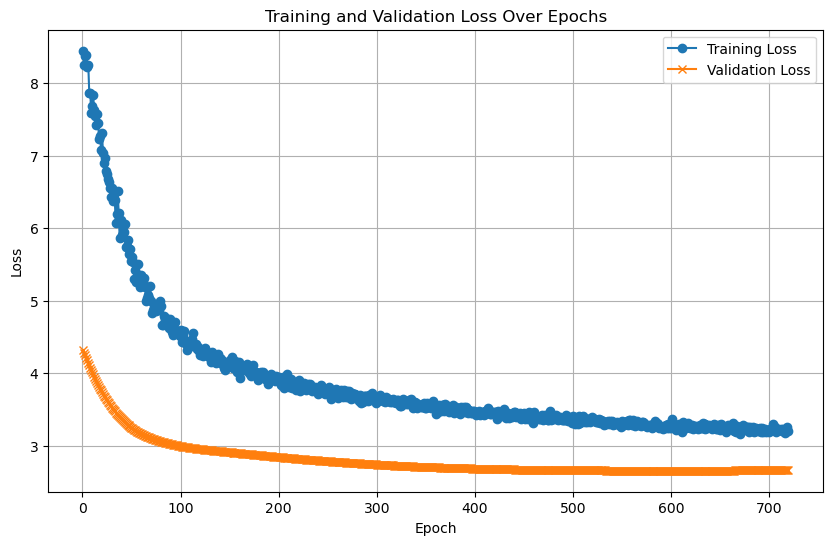

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 5.3326
Test Batch [20/167], Loss: 5.1346
Test Batch [30/167], Loss: 5.1061
Test Batch [40/167], Loss: 5.3154
Test Batch [50/167], Loss: 5.1427
Test Batch [60/167], Loss: 5.2038
Test Batch [70/167], Loss: 5.2302


Test Batch [80/167], Loss: 5.4345
Test Batch [90/167], Loss: 4.9606
Test Batch [100/167], Loss: 4.5933
Test Batch [110/167], Loss: 4.6730
Test Batch [120/167], Loss: 4.5916
Test Batch [130/167], Loss: 4.6204
Test Batch [140/167], Loss: 4.5649


Test Batch [150/167], Loss: 4.8792
Test Batch [160/167], Loss: 5.1436

Test Loss: 4.9753


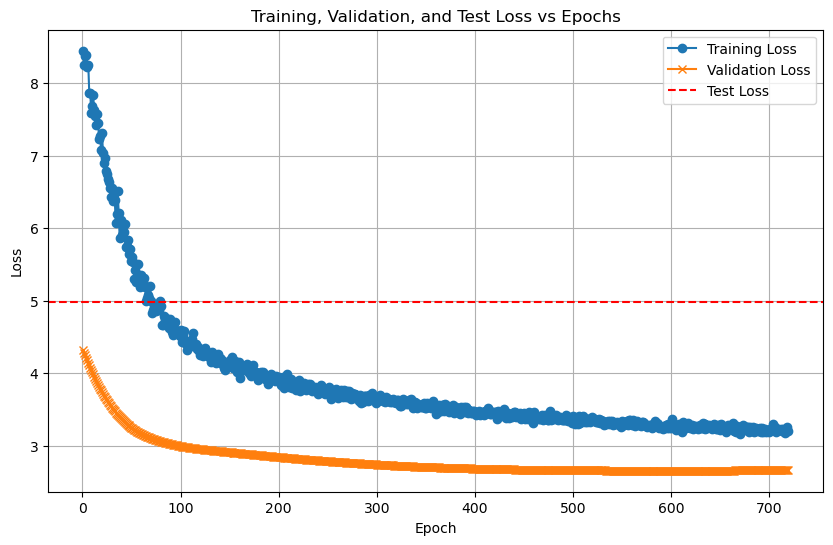

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.


  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.


  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       1.00      0.80      0.89         5
           2       0.60      0.60      0.60         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.67      0.80      0.73         5
           7       0.75      0.60      0.67         5
           8       0.83      1.00      0.91         5

    accuracy                           0.80        45
   macro avg       0.81      0.80      0.80        45
weighted avg       0.81      0.80      0.80        45


LOG: Evaluating on the test set...
Test Accuracy: 62.75%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2408  |  Val Loss: 2.2435
Validation loss improved from inf to 2.2435.
[Epoch 2/1000] Train Loss: 2.2112  |  Val Loss: 2.2182
Validation loss improved from 2.2435 to 2.2182.
[Epoch 3/1000] Train Loss: 2.1831  |  Val Loss: 2.1939
Validation loss improved from 2.2182 to 2.1939.
[Epoch 4/1000] Train Loss: 2.1592  |  Val Loss: 2.1714
Validation loss improved from 2.1939 to 2.1714.
[Epoch 5/1000] Train Loss: 2.1353  |  Val Loss: 2.1505
Validation loss improved from 2.1714 to 2.1505.
[Epoch 6/1000] Train Loss: 2.1150  |  Val Loss: 2.1317
Validation loss improved from 2.1505 to 2.1317.
[Epoch 7/1000] Train Loss: 2.0964  |  Val Loss: 2.1136
Validation loss improved from 2.1317 to 2.1136.
[Epoch 8/1000] Train Loss: 2.0788  |  Val Loss: 2.0959
Validation loss improved from 2.1136 to 2.0959.


[Epoch 9/1000] Train Loss: 2.0610  |  Val Loss: 2.0790
Validation loss improved from 2.0959 to 2.0790.
[Epoch 10/1000] Train Loss: 2.0454  |  Val Loss: 2.0627
Validation loss improved from 2.0790 to 2.0627.
[Epoch 11/1000] Train Loss: 2.0289  |  Val Loss: 2.0470
Validation loss improved from 2.0627 to 2.0470.
[Epoch 12/1000] Train Loss: 2.0129  |  Val Loss: 2.0317
Validation loss improved from 2.0470 to 2.0317.
[Epoch 13/1000] Train Loss: 1.9985  |  Val Loss: 2.0169
Validation loss improved from 2.0317 to 2.0169.
[Epoch 14/1000] Train Loss: 1.9834  |  Val Loss: 2.0026
Validation loss improved from 2.0169 to 2.0026.
[Epoch 15/1000] Train Loss: 1.9694  |  Val Loss: 1.9885
Validation loss improved from 2.0026 to 1.9885.
[Epoch 16/1000] Train Loss: 1.9557  |  Val Loss: 1.9748
Validation loss improved from 1.9885 to 1.9748.
[Epoch 17/1000] Train Loss: 1.9426  |  Val Loss: 1.9615
Validation loss improved from 1.9748 to 1.9615.
[Epoch 18/1000] Train Loss: 1.9284  |  Val Loss: 1.9486
Validatio

[Epoch 43/1000] Train Loss: 1.6418  |  Val Loss: 1.6855
Validation loss improved from 1.6948 to 1.6855.
[Epoch 44/1000] Train Loss: 1.6314  |  Val Loss: 1.6761
Validation loss improved from 1.6855 to 1.6761.
[Epoch 45/1000] Train Loss: 1.6218  |  Val Loss: 1.6668
Validation loss improved from 1.6761 to 1.6668.
[Epoch 46/1000] Train Loss: 1.6115  |  Val Loss: 1.6578
Validation loss improved from 1.6668 to 1.6578.
[Epoch 47/1000] Train Loss: 1.6016  |  Val Loss: 1.6487
Validation loss improved from 1.6578 to 1.6487.
[Epoch 48/1000] Train Loss: 1.5921  |  Val Loss: 1.6397
Validation loss improved from 1.6487 to 1.6397.
[Epoch 49/1000] Train Loss: 1.5825  |  Val Loss: 1.6308
Validation loss improved from 1.6397 to 1.6308.
[Epoch 50/1000] Train Loss: 1.5725  |  Val Loss: 1.6219
Validation loss improved from 1.6308 to 1.6219.
[Epoch 51/1000] Train Loss: 1.5631  |  Val Loss: 1.6130
Validation loss improved from 1.6219 to 1.6130.
[Epoch 52/1000] Train Loss: 1.5534  |  Val Loss: 1.6040
Validati

[Epoch 58/1000] Train Loss: 1.4964  |  Val Loss: 1.5509
Validation loss improved from 1.5595 to 1.5509.
[Epoch 59/1000] Train Loss: 1.4868  |  Val Loss: 1.5424
Validation loss improved from 1.5509 to 1.5424.
[Epoch 60/1000] Train Loss: 1.4774  |  Val Loss: 1.5340
Validation loss improved from 1.5424 to 1.5340.
[Epoch 61/1000] Train Loss: 1.4680  |  Val Loss: 1.5258
Validation loss improved from 1.5340 to 1.5258.
[Epoch 62/1000] Train Loss: 1.4587  |  Val Loss: 1.5177
Validation loss improved from 1.5258 to 1.5177.
[Epoch 63/1000] Train Loss: 1.4498  |  Val Loss: 1.5098
Validation loss improved from 1.5177 to 1.5098.
[Epoch 64/1000] Train Loss: 1.4406  |  Val Loss: 1.5019
Validation loss improved from 1.5098 to 1.5019.
[Epoch 65/1000] Train Loss: 1.4318  |  Val Loss: 1.4942
Validation loss improved from 1.5019 to 1.4942.
[Epoch 66/1000] Train Loss: 1.4227  |  Val Loss: 1.4869
Validation loss improved from 1.4942 to 1.4869.
[Epoch 67/1000] Train Loss: 1.4142  |  Val Loss: 1.4797
Validati

[Epoch 88/1000] Train Loss: 1.2462  |  Val Loss: 1.3394
Validation loss improved from 1.3449 to 1.3394.
[Epoch 89/1000] Train Loss: 1.2392  |  Val Loss: 1.3340
Validation loss improved from 1.3394 to 1.3340.
[Epoch 90/1000] Train Loss: 1.2325  |  Val Loss: 1.3285
Validation loss improved from 1.3340 to 1.3285.
[Epoch 91/1000] Train Loss: 1.2257  |  Val Loss: 1.3230
Validation loss improved from 1.3285 to 1.3230.
[Epoch 92/1000] Train Loss: 1.2189  |  Val Loss: 1.3177
Validation loss improved from 1.3230 to 1.3177.
[Epoch 93/1000] Train Loss: 1.2121  |  Val Loss: 1.3123
Validation loss improved from 1.3177 to 1.3123.
[Epoch 94/1000] Train Loss: 1.2053  |  Val Loss: 1.3071
Validation loss improved from 1.3123 to 1.3071.
[Epoch 95/1000] Train Loss: 1.1986  |  Val Loss: 1.3016
Validation loss improved from 1.3071 to 1.3016.
[Epoch 96/1000] Train Loss: 1.1920  |  Val Loss: 1.2962
Validation loss improved from 1.3016 to 1.2962.


[Epoch 97/1000] Train Loss: 1.1855  |  Val Loss: 1.2910
Validation loss improved from 1.2962 to 1.2910.
[Epoch 98/1000] Train Loss: 1.1789  |  Val Loss: 1.2858
Validation loss improved from 1.2910 to 1.2858.
[Epoch 99/1000] Train Loss: 1.1725  |  Val Loss: 1.2806
Validation loss improved from 1.2858 to 1.2806.
[Epoch 100/1000] Train Loss: 1.1661  |  Val Loss: 1.2755
Validation loss improved from 1.2806 to 1.2755.
[Epoch 101/1000] Train Loss: 1.1598  |  Val Loss: 1.2705
Validation loss improved from 1.2755 to 1.2705.
[Epoch 102/1000] Train Loss: 1.1532  |  Val Loss: 1.2654
Validation loss improved from 1.2705 to 1.2654.
[Epoch 103/1000] Train Loss: 1.1470  |  Val Loss: 1.2602
Validation loss improved from 1.2654 to 1.2602.
[Epoch 104/1000] Train Loss: 1.1407  |  Val Loss: 1.2549
Validation loss improved from 1.2602 to 1.2549.
[Epoch 105/1000] Train Loss: 1.1344  |  Val Loss: 1.2495
Validation loss improved from 1.2549 to 1.2495.
[Epoch 106/1000] Train Loss: 1.1282  |  Val Loss: 1.2439
V

[Epoch 132/1000] Train Loss: 0.9741  |  Val Loss: 1.1227
Validation loss improved from 1.1266 to 1.1227.
[Epoch 133/1000] Train Loss: 0.9689  |  Val Loss: 1.1188
Validation loss improved from 1.1227 to 1.1188.
[Epoch 134/1000] Train Loss: 0.9637  |  Val Loss: 1.1150
Validation loss improved from 1.1188 to 1.1150.
[Epoch 135/1000] Train Loss: 0.9588  |  Val Loss: 1.1112
Validation loss improved from 1.1150 to 1.1112.
[Epoch 136/1000] Train Loss: 0.9538  |  Val Loss: 1.1073
Validation loss improved from 1.1112 to 1.1073.
[Epoch 137/1000] Train Loss: 0.9486  |  Val Loss: 1.1034
Validation loss improved from 1.1073 to 1.1034.
[Epoch 138/1000] Train Loss: 0.9440  |  Val Loss: 1.0995
Validation loss improved from 1.1034 to 1.0995.
[Epoch 139/1000] Train Loss: 0.9389  |  Val Loss: 1.0960
Validation loss improved from 1.0995 to 1.0960.
[Epoch 140/1000] Train Loss: 0.9341  |  Val Loss: 1.0925
Validation loss improved from 1.0960 to 1.0925.
[Epoch 141/1000] Train Loss: 0.9293  |  Val Loss: 1.089

[Epoch 142/1000] Train Loss: 0.9244  |  Val Loss: 1.0860
Validation loss improved from 1.0892 to 1.0860.
[Epoch 143/1000] Train Loss: 0.9198  |  Val Loss: 1.0828
Validation loss improved from 1.0860 to 1.0828.
[Epoch 144/1000] Train Loss: 0.9151  |  Val Loss: 1.0796
Validation loss improved from 1.0828 to 1.0796.
[Epoch 145/1000] Train Loss: 0.9104  |  Val Loss: 1.0765
Validation loss improved from 1.0796 to 1.0765.
[Epoch 146/1000] Train Loss: 0.9058  |  Val Loss: 1.0734
Validation loss improved from 1.0765 to 1.0734.
[Epoch 147/1000] Train Loss: 0.9012  |  Val Loss: 1.0702
Validation loss improved from 1.0734 to 1.0702.
[Epoch 148/1000] Train Loss: 0.8967  |  Val Loss: 1.0671
Validation loss improved from 1.0702 to 1.0671.
[Epoch 149/1000] Train Loss: 0.8921  |  Val Loss: 1.0643
Validation loss improved from 1.0671 to 1.0643.
[Epoch 150/1000] Train Loss: 0.8877  |  Val Loss: 1.0614
Validation loss improved from 1.0643 to 1.0614.
[Epoch 151/1000] Train Loss: 0.8831  |  Val Loss: 1.058

[Epoch 175/1000] Train Loss: 0.7868  |  Val Loss: 0.9968
Validation loss improved from 0.9989 to 0.9968.
[Epoch 176/1000] Train Loss: 0.7837  |  Val Loss: 0.9947
Validation loss improved from 0.9968 to 0.9947.
[Epoch 177/1000] Train Loss: 0.7800  |  Val Loss: 0.9924
Validation loss improved from 0.9947 to 0.9924.
[Epoch 178/1000] Train Loss: 0.7764  |  Val Loss: 0.9902
Validation loss improved from 0.9924 to 0.9902.
[Epoch 179/1000] Train Loss: 0.7732  |  Val Loss: 0.9880
Validation loss improved from 0.9902 to 0.9880.
[Epoch 180/1000] Train Loss: 0.7697  |  Val Loss: 0.9858
Validation loss improved from 0.9880 to 0.9858.
[Epoch 181/1000] Train Loss: 0.7665  |  Val Loss: 0.9833
Validation loss improved from 0.9858 to 0.9833.
[Epoch 182/1000] Train Loss: 0.7631  |  Val Loss: 0.9807
Validation loss improved from 0.9833 to 0.9807.
[Epoch 183/1000] Train Loss: 0.7600  |  Val Loss: 0.9781
Validation loss improved from 0.9807 to 0.9781.
[Epoch 184/1000] Train Loss: 0.7567  |  Val Loss: 0.975

[Epoch 185/1000] Train Loss: 0.7537  |  Val Loss: 0.9729
Validation loss improved from 0.9754 to 0.9729.
[Epoch 186/1000] Train Loss: 0.7507  |  Val Loss: 0.9710
Validation loss improved from 0.9729 to 0.9710.
[Epoch 187/1000] Train Loss: 0.7476  |  Val Loss: 0.9694
Validation loss improved from 0.9710 to 0.9694.
[Epoch 188/1000] Train Loss: 0.7442  |  Val Loss: 0.9682
Validation loss improved from 0.9694 to 0.9682.
[Epoch 189/1000] Train Loss: 0.7413  |  Val Loss: 0.9667
Validation loss improved from 0.9682 to 0.9667.
[Epoch 190/1000] Train Loss: 0.7381  |  Val Loss: 0.9651
Validation loss improved from 0.9667 to 0.9651.
[Epoch 191/1000] Train Loss: 0.7357  |  Val Loss: 0.9634
Validation loss improved from 0.9651 to 0.9634.
[Epoch 192/1000] Train Loss: 0.7321  |  Val Loss: 0.9610
Validation loss improved from 0.9634 to 0.9610.
[Epoch 193/1000] Train Loss: 0.7290  |  Val Loss: 0.9585
Validation loss improved from 0.9610 to 0.9585.
[Epoch 194/1000] Train Loss: 0.7260  |  Val Loss: 0.956

[Epoch 217/1000] Train Loss: 0.6653  |  Val Loss: 0.9206
Validation loss improved from 0.9213 to 0.9206.
[Epoch 218/1000] Train Loss: 0.6633  |  Val Loss: 0.9198
Validation loss improved from 0.9206 to 0.9198.
[Epoch 219/1000] Train Loss: 0.6608  |  Val Loss: 0.9187
Validation loss improved from 0.9198 to 0.9187.
[Epoch 220/1000] Train Loss: 0.6585  |  Val Loss: 0.9175
Validation loss improved from 0.9187 to 0.9175.
[Epoch 221/1000] Train Loss: 0.6563  |  Val Loss: 0.9164
Validation loss improved from 0.9175 to 0.9164.
[Epoch 222/1000] Train Loss: 0.6544  |  Val Loss: 0.9153
Validation loss improved from 0.9164 to 0.9153.
[Epoch 223/1000] Train Loss: 0.6521  |  Val Loss: 0.9138
Validation loss improved from 0.9153 to 0.9138.
[Epoch 224/1000] Train Loss: 0.6497  |  Val Loss: 0.9123
Validation loss improved from 0.9138 to 0.9123.
[Epoch 225/1000] Train Loss: 0.6477  |  Val Loss: 0.9110
Validation loss improved from 0.9123 to 0.9110.
[Epoch 226/1000] Train Loss: 0.6458  |  Val Loss: 0.910

[Epoch 227/1000] Train Loss: 0.6434  |  Val Loss: 0.9086
Validation loss improved from 0.9100 to 0.9086.
[Epoch 228/1000] Train Loss: 0.6413  |  Val Loss: 0.9073
Validation loss improved from 0.9086 to 0.9073.
[Epoch 229/1000] Train Loss: 0.6396  |  Val Loss: 0.9059
Validation loss improved from 0.9073 to 0.9059.
[Epoch 230/1000] Train Loss: 0.6372  |  Val Loss: 0.9047
Validation loss improved from 0.9059 to 0.9047.
[Epoch 231/1000] Train Loss: 0.6353  |  Val Loss: 0.9039
Validation loss improved from 0.9047 to 0.9039.
[Epoch 232/1000] Train Loss: 0.6329  |  Val Loss: 0.9031
Validation loss improved from 0.9039 to 0.9031.
[Epoch 233/1000] Train Loss: 0.6310  |  Val Loss: 0.9023
Validation loss improved from 0.9031 to 0.9023.
[Epoch 234/1000] Train Loss: 0.6297  |  Val Loss: 0.9017
Validation loss improved from 0.9023 to 0.9017.
[Epoch 235/1000] Train Loss: 0.6272  |  Val Loss: 0.9012
Validation loss improved from 0.9017 to 0.9012.
[Epoch 236/1000] Train Loss: 0.6254  |  Val Loss: 0.901

[Epoch 262/1000] Train Loss: 0.5832  |  Val Loss: 0.8834
Validation loss improved from 0.8836 to 0.8834.
[Epoch 263/1000] Train Loss: 0.5812  |  Val Loss: 0.8826
Validation loss improved from 0.8834 to 0.8826.
[Epoch 264/1000] Train Loss: 0.5797  |  Val Loss: 0.8816
Validation loss improved from 0.8826 to 0.8816.
[Epoch 265/1000] Train Loss: 0.5780  |  Val Loss: 0.8803
Validation loss improved from 0.8816 to 0.8803.
[Epoch 266/1000] Train Loss: 0.5765  |  Val Loss: 0.8790
Validation loss improved from 0.8803 to 0.8790.
[Epoch 267/1000] Train Loss: 0.5755  |  Val Loss: 0.8776
Validation loss improved from 0.8790 to 0.8776.
[Epoch 268/1000] Train Loss: 0.5738  |  Val Loss: 0.8765
Validation loss improved from 0.8776 to 0.8765.
[Epoch 269/1000] Train Loss: 0.5726  |  Val Loss: 0.8756
Validation loss improved from 0.8765 to 0.8756.
[Epoch 270/1000] Train Loss: 0.5716  |  Val Loss: 0.8750
Validation loss improved from 0.8756 to 0.8750.


[Epoch 271/1000] Train Loss: 0.5699  |  Val Loss: 0.8751
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 272/1000] Train Loss: 0.5685  |  Val Loss: 0.8750
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 273/1000] Train Loss: 0.5670  |  Val Loss: 0.8750
Validation loss improved from 0.8750 to 0.8750.
[Epoch 274/1000] Train Loss: 0.5656  |  Val Loss: 0.8753
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 275/1000] Train Loss: 0.5645  |  Val Loss: 0.8758
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 276/1000] Train Loss: 0.5631  |  Val Loss: 0.8761
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 277/1000] Train Loss: 0.5616  |  Val Loss: 0.8765
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 278/1000] Train Loss: 0.5608  |  Val Loss: 0.8769
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 279/1000] Train Loss: 0.5595  |  Val Loss: 0.8768
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 302/1000] Train Loss: 0.5330  |  Val Loss: 0.8685
Validation loss improved from 0.8695 to 0.8685.
[Epoch 303/1000] Train Loss: 0.5315  |  Val Loss: 0.8677
Validation loss improved from 0.8685 to 0.8677.
[Epoch 304/1000] Train Loss: 0.5304  |  Val Loss: 0.8669
Validation loss improved from 0.8677 to 0.8669.
[Epoch 305/1000] Train Loss: 0.5291  |  Val Loss: 0.8660
Validation loss improved from 0.8669 to 0.8660.
[Epoch 306/1000] Train Loss: 0.5276  |  Val Loss: 0.8656
Validation loss improved from 0.8660 to 0.8656.
[Epoch 307/1000] Train Loss: 0.5266  |  Val Loss: 0.8655
Validation loss improved from 0.8656 to 0.8655.
[Epoch 308/1000] Train Loss: 0.5253  |  Val Loss: 0.8660
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 309/1000] Train Loss: 0.5240  |  Val Loss: 0.8669
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 310/1000] Train Loss: 0.5231  |  Val Loss: 0.8678
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 311/1000] Train Loss: 0.5225  |  Val Loss: 0.8683
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 312/1000] Train Loss: 0.5214  |  Val Loss: 0.8681
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 313/1000] Train Loss: 0.5204  |  Val Loss: 0.8676
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 314/1000] Train Loss: 0.5192  |  Val Loss: 0.8669
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 315/1000] Train Loss: 0.5180  |  Val Loss: 0.8656
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 316/1000] Train Loss: 0.5171  |  Val Loss: 0.8641
Validation loss improved from 0.8655 to 0.8641.
[Epoch 317/1000] Train Loss: 0.5158  |  Val Loss: 0.8630
Validation loss improved from 0.8641 to 0.8630.
[Epoch 318/1000] Train Loss: 0.5148  |  Val Loss: 0.8621
Validation loss improved from 0.8630 to 0.8621.
[Epoch 319/1000] Tr

[Epoch 347/1000] Train Loss: 0.4905  |  Val Loss: 0.8607
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 348/1000] Train Loss: 0.4896  |  Val Loss: 0.8609
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 349/1000] Train Loss: 0.4886  |  Val Loss: 0.8618
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 350/1000] Train Loss: 0.4879  |  Val Loss: 0.8626
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 351/1000] Train Loss: 0.4876  |  Val Loss: 0.8634
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 352/1000] Train Loss: 0.4865  |  Val Loss: 0.8639
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 353/1000] Train Loss: 0.4859  |  Val Loss: 0.8641
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 354/1000] Train Loss: 0.4855  |  Val Loss: 0.8640
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 355/1000] Train Loss: 0.4847  |  Val Loss: 0.8634
!! Validation loss did NOT improve !! Patience:

[Epoch 360/1000] Train Loss: 0.4811  |  Val Loss: 0.8649
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 361/1000] Train Loss: 0.4801  |  Val Loss: 0.8643
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 362/1000] Train Loss: 0.4795  |  Val Loss: 0.8640
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 363/1000] Train Loss: 0.4787  |  Val Loss: 0.8645
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 364/1000] Train Loss: 0.4779  |  Val Loss: 0.8646
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 365/1000] Train Loss: 0.4773  |  Val Loss: 0.8647
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 366/1000] Train Loss: 0.4765  |  Val Loss: 0.8645
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 367/1000] Train Loss: 0.4762  |  Val Loss: 0.8642
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 368/1000] Train Loss: 0.4753  |  Val Loss: 0.8638
!! Validation loss did NOT improve !! Patience:

[Epoch 390/1000] Train Loss: 0.4611  |  Val Loss: 0.8631
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 391/1000] Train Loss: 0.4608  |  Val Loss: 0.8648
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 392/1000] Train Loss: 0.4602  |  Val Loss: 0.8660
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 393/1000] Train Loss: 0.4595  |  Val Loss: 0.8671
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 394/1000] Train Loss: 0.4590  |  Val Loss: 0.8687
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 395/1000] Train Loss: 0.4587  |  Val Loss: 0.8697
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 396/1000] Train Loss: 0.4580  |  Val Loss: 0.8698
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 397/1000] Train Loss: 0.4575  |  Val Loss: 0.8690
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 398/1000] Train Loss: 0.4570  |  Val Loss: 0.8684
!! Validation loss did NOT improve !! Patience:

[Epoch 401/1000] Train Loss: 0.4551  |  Val Loss: 0.8675
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 402/1000] Train Loss: 0.4543  |  Val Loss: 0.8669
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 403/1000] Train Loss: 0.4537  |  Val Loss: 0.8664
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 404/1000] Train Loss: 0.4532  |  Val Loss: 0.8659
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 405/1000] Train Loss: 0.4527  |  Val Loss: 0.8656
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 406/1000] Train Loss: 0.4526  |  Val Loss: 0.8656
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 407/1000] Train Loss: 0.4521  |  Val Loss: 0.8653
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 408/1000] Train Loss: 0.4515  |  Val Loss: 0.8660
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 409/1000] Train Loss: 0.4511  |  Val Loss: 0.8668
!! Validation loss did NOT improve !! Patience:

[Epoch 435/1000] Train Loss: 0.4368  |  Val Loss: 0.8742
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 436/1000] Train Loss: 0.4364  |  Val Loss: 0.8751
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 437/1000] Train Loss: 0.4357  |  Val Loss: 0.8752
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 438/1000] Train Loss: 0.4351  |  Val Loss: 0.8752
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 439/1000] Train Loss: 0.4345  |  Val Loss: 0.8752
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 440/1000] Train Loss: 0.4339  |  Val Loss: 0.8751
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 441/1000] Train Loss: 0.4332  |  Val Loss: 0.8738
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 442/1000] Train Loss: 0.4325  |  Val Loss: 0.8722
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 443/1000] Train Loss: 0.4317  |  Val Loss: 0.8713
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 444/1000] Train Loss: 0.4312  |  Val Loss: 0.8707
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 445/1000] Train Loss: 0.4307  |  Val Loss: 0.8696
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 446/1000] Train Loss: 0.4303  |  Val Loss: 0.8688
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 447/1000] Train Loss: 0.4295  |  Val Loss: 0.8685
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 448/1000] Train Loss: 0.4294  |  Val Loss: 0.8683
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 449/1000] Train Loss: 0.4288  |  Val Loss: 0.8690
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 450/1000] Train Loss: 0.4281  |  Val Loss: 0.8695
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 451/1000] Train Loss: 0.4282  |  Val Loss: 0.8701
!! Validation loss did NOT improve !! Patience:

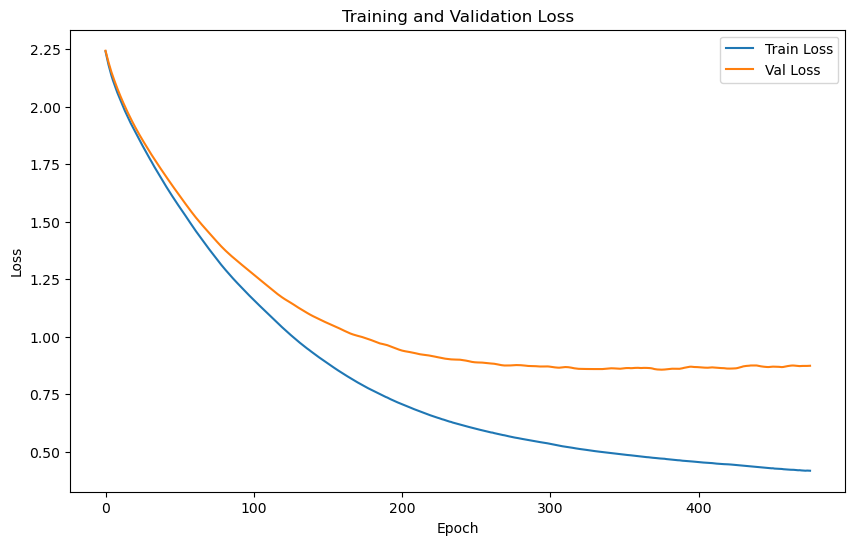

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.0238 | Test Accuracy: 63.95%


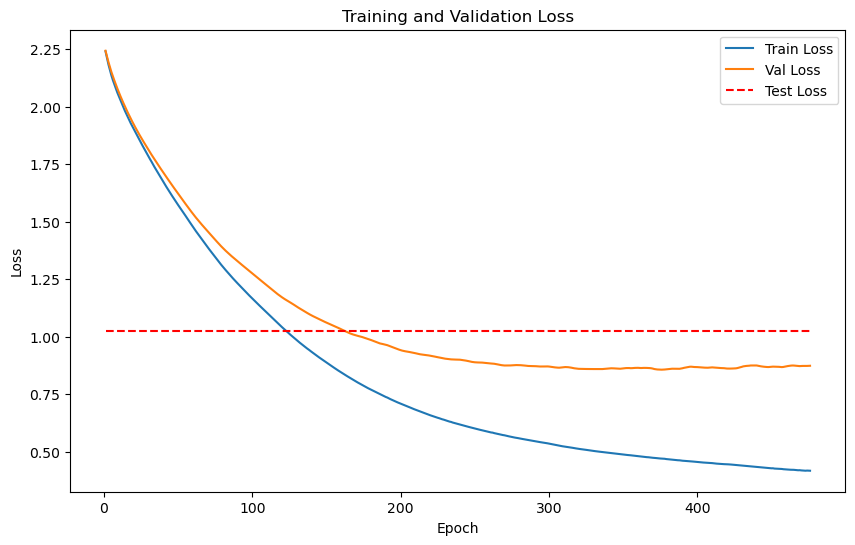

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42641 samples with 64 features each
LOG: Labels shape: (42641,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42641, 64), 
Test labels shape: (42641,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4415
Epoch [1/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.4415

Validation loss improved from inf to 0.4415. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4404
Epoch [2/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4404

Validation loss improved from 0.4415 to 0.4404. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4387
Epoch [3/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4387

Validation loss improved from 0.4404 to 0.4387. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4361
Epoch [4/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4361

Validation loss improved from 0.4387 to 0.4361. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4330
Epoch [5/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4330

Validation loss improved from 0.4361 to 0.4330. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.4299
Epoch [6/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4299

Validation loss improved from 0.4330 to 0.4299. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4265
Epoch [7/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4265

Validation loss improved from 0.4299 to 0.4265. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4220
Epoch [8/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4220

Validation loss improved from 0.4265 to 0.4220. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.4175
Epoch [9/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4175

Validation loss improved from 0.4220 to 0.4175. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4137
Epoch [10/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4137

Validation loss improved from 0.4175 to 0.4137. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4104
Epoch [11/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4104

Validation loss improved from 0.4137 to 0.4104. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4076
Epoch [12/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4076

Validation loss improved from 0.4104 to 0.4076. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4054
Epoch [13/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4054

Validation loss improved from 0.4076 to 0.4054. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.4035
Epoch [14/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4035

Validation loss improved from 0.4054 to 0.4035. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4018
Epoch [15/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4018

Validation loss improved from 0.4035 to 0.4018. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.4005
Epoch [16/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4005

Validation loss improved from 0.4018 to 0.4005. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [17/2000] - Validation


    Batch [1/1], Val Loss: 0.3994
Epoch [17/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3994

Validation loss improved from 0.4005 to 0.3994. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [18/2000] - Validation


    Batch [1/1], Val Loss: 0.3985
Epoch [18/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.3985

Validation loss improved from 0.3994 to 0.3985. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.3977
Epoch [19/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3977

Validation loss improved from 0.3985 to 0.3977. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3969
Epoch [20/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.3969

Validation loss improved from 0.3977 to 0.3969. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [21/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3962

Validation loss improved from 0.3969 to 0.3962. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3957
Epoch [22/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3957

Validation loss improved from 0.3962 to 0.3957. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3953
Epoch [23/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3953

Validation loss improved from 0.3957 to 0.3953. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [24/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3949

Validation loss improved from 0.3953 to 0.3949. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.3945
Epoch [25/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3945

Validation loss improved from 0.3949 to 0.3945. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3941
Epoch [26/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3941

Validation loss improved from 0.3945 to 0.3941. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3937
Epoch [27/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3937

Validation loss improved from 0.3941 to 0.3937. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3933
Epoch [28/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3933

Validation loss improved from 0.3937 to 0.3933. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.3930
Epoch [29/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3930

Validation loss improved from 0.3933 to 0.3930. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [30/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3927

Validation loss improved from 0.3930 to 0.3927. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3923
Epoch [31/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.3923

Validation loss improved from 0.3927 to 0.3923. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3919
Epoch [32/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3919

Validation loss improved from 0.3923 to 0.3919. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [33/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3916

Validation loss improved from 0.3919 to 0.3916. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [34/2000] - Validation


    Batch [1/1], Val Loss: 0.3912
Epoch [34/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.3912

Validation loss improved from 0.3916 to 0.3912. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3909
Epoch [35/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.3909

Validation loss improved from 0.3912 to 0.3909. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [36/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3905

Validation loss improved from 0.3909 to 0.3905. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3901
Epoch [37/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3901

Validation loss improved from 0.3905 to 0.3901. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3897
Epoch [38/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3897

Validation loss improved from 0.3901 to 0.3897. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [39/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3894

Validation loss improved from 0.3897 to 0.3894. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3890
Epoch [40/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3890

Validation loss improved from 0.3894 to 0.3890. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3886
Epoch [41/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.3886

Validation loss improved from 0.3890 to 0.3886. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [42/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.3883

Validation loss improved from 0.3886 to 0.3883. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [43/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.3879

Validation loss improved from 0.3883 to 0.3879. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3876
Epoch [44/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.3876

Validation loss improved from 0.3879 to 0.3876. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3872
Epoch [45/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.3872

Validation loss improved from 0.3876 to 0.3872. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3869
Epoch [46/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3869

Validation loss improved from 0.3872 to 0.3869. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3866
Epoch [47/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.3866

Validation loss improved from 0.3869 to 0.3866. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3862
Epoch [48/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.3862

Validation loss improved from 0.3866 to 0.3862. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3859
Epoch [49/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3859

Validation loss improved from 0.3862 to 0.3859. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [50/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.3856

Validation loss improved from 0.3859 to 0.3856. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [51/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3853

Validation loss improved from 0.3856 to 0.3853. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [52/2000] - Validation


    Batch [1/1], Val Loss: 0.3851
Epoch [52/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.3851

Validation loss improved from 0.3853 to 0.3851. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [53/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.3848

Validation loss improved from 0.3851 to 0.3848. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [54/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3845

Validation loss improved from 0.3848 to 0.3845. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [55/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.3843

Validation loss improved from 0.3845 to 0.3843. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3840
Epoch [56/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.3840

Validation loss improved from 0.3843 to 0.3840. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3837
Epoch [57/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3837

Validation loss improved from 0.3840 to 0.3837. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3835
Epoch [58/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3835

Validation loss improved from 0.3837 to 0.3835. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [59/2000] - Validation


    Batch [1/1], Val Loss: 0.3833
Epoch [59/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3833

Validation loss improved from 0.3835 to 0.3833. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3830
Epoch [60/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3830

Validation loss improved from 0.3833 to 0.3830. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.3828
Epoch [61/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3828

Validation loss improved from 0.3830 to 0.3828. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3825
Epoch [62/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3825

Validation loss improved from 0.3828 to 0.3825. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3823
Epoch [63/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.3823

Validation loss improved from 0.3825 to 0.3823. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3821
Epoch [64/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.3821

Validation loss improved from 0.3823 to 0.3821. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3818
Epoch [65/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3818

Validation loss improved from 0.3821 to 0.3818. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [66/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.3816

Validation loss improved from 0.3818 to 0.3816. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [67/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.3813

Validation loss improved from 0.3816 to 0.3813. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3811
Epoch [68/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.3811

Validation loss improved from 0.3813 to 0.3811. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [69/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3808

Validation loss improved from 0.3811 to 0.3808. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3806
Epoch [70/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3806

Validation loss improved from 0.3808 to 0.3806. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [71/2000] - Validation


    Batch [1/1], Val Loss: 0.3803
Epoch [71/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.3803

Validation loss improved from 0.3806 to 0.3803. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3801
Epoch [72/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3801

Validation loss improved from 0.3803 to 0.3801. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [73/2000] - Validation


    Batch [1/1], Val Loss: 0.3798
Epoch [73/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.3798

Validation loss improved from 0.3801 to 0.3798. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3796
Epoch [74/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3796

Validation loss improved from 0.3798 to 0.3796. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3793
Epoch [75/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3793

Validation loss improved from 0.3796 to 0.3793. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3791
Epoch [76/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3791

Validation loss improved from 0.3793 to 0.3791. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [77/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3789

Validation loss improved from 0.3791 to 0.3789. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [78/2000] - Validation


    Batch [1/1], Val Loss: 0.3787
Epoch [78/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.3787

Validation loss improved from 0.3789 to 0.3787. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [79/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3785

Validation loss improved from 0.3787 to 0.3785. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [80/2000] - Validation


    Batch [1/1], Val Loss: 0.3783
Epoch [80/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3783

Validation loss improved from 0.3785 to 0.3783. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [81/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3781

Validation loss improved from 0.3783 to 0.3781. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [82/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3779

Validation loss improved from 0.3781 to 0.3779. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3776
Epoch [83/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3776

Validation loss improved from 0.3779 to 0.3776. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [84/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3774

Validation loss improved from 0.3776 to 0.3774. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [85/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3772

Validation loss improved from 0.3774 to 0.3772. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [86/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3770

Validation loss improved from 0.3772 to 0.3770. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [87/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3768

Validation loss improved from 0.3770 to 0.3768. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [88/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3766

Validation loss improved from 0.3768 to 0.3766. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [89/2000] - Validation


    Batch [1/1], Val Loss: 0.3764
Epoch [89/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3764

Validation loss improved from 0.3766 to 0.3764. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [90/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3763

Validation loss improved from 0.3764 to 0.3763. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [91/2000] - Validation


    Batch [1/1], Val Loss: 0.3761
Epoch [91/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3761

Validation loss improved from 0.3763 to 0.3761. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [92/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3760

Validation loss improved from 0.3761 to 0.3760. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [93/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3759

Validation loss improved from 0.3760 to 0.3759. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [94/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3757

Validation loss improved from 0.3759 to 0.3757. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [95/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [96/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3755

Validation loss improved from 0.3756 to 0.3755. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3753
Epoch [97/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3753

Validation loss improved from 0.3755 to 0.3753. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [98/2000] - Validation


    Batch [1/1], Val Loss: 0.3752
Epoch [98/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3752

Validation loss improved from 0.3753 to 0.3752. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3751
Epoch [99/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3751

Validation loss improved from 0.3752 to 0.3751. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [100/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3749

Validation loss improved from 0.3751 to 0.3749. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3748
Epoch [101/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3748

Validation loss improved from 0.3749 to 0.3748. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [102/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3747

Validation loss improved from 0.3748 to 0.3747. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [103/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3745

Validation loss improved from 0.3747 to 0.3745. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3744
Epoch [104/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3744

Validation loss improved from 0.3745 to 0.3744. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [105/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3743

Validation loss improved from 0.3744 to 0.3743. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3742
Epoch [106/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3742

Validation loss improved from 0.3743 to 0.3742. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3741
Epoch [107/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3741

Validation loss improved from 0.3742 to 0.3741. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3740
Epoch [108/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3740

Validation loss improved from 0.3741 to 0.3740. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [109/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.3739

Validation loss improved from 0.3740 to 0.3739. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [110/2000] - Validation


    Batch [1/1], Val Loss: 0.3738
Epoch [110/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3738

Validation loss improved from 0.3739 to 0.3738. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [111/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3736

Validation loss improved from 0.3738 to 0.3736. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.3735
Epoch [112/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3735

Validation loss improved from 0.3736 to 0.3735. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [113/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3734

Validation loss improved from 0.3735 to 0.3734. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.3733
Epoch [114/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3733

Validation loss improved from 0.3734 to 0.3733. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3732
Epoch [115/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3732

Validation loss improved from 0.3733 to 0.3732. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [116/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.3730

Validation loss improved from 0.3732 to 0.3730. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3729
Epoch [117/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3729

Validation loss improved from 0.3730 to 0.3729. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3727
Epoch [118/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.3727

Validation loss improved from 0.3729 to 0.3727. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [119/2000] - Validation


    Batch [1/1], Val Loss: 0.3726
Epoch [119/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3726

Validation loss improved from 0.3727 to 0.3726. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [120/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3724

Validation loss improved from 0.3726 to 0.3724. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3723
Epoch [121/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3723

Validation loss improved from 0.3724 to 0.3723. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3722
Epoch [122/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3722

Validation loss improved from 0.3723 to 0.3722. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3720
Epoch [123/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3720

Validation loss improved from 0.3722 to 0.3720. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [124/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3719

Validation loss improved from 0.3720 to 0.3719. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3718
Epoch [125/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.3718

Validation loss improved from 0.3719 to 0.3718. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [126/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3717

Validation loss improved from 0.3718 to 0.3717. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3716
Epoch [127/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3716

Validation loss improved from 0.3717 to 0.3716. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [128/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3715

Validation loss improved from 0.3716 to 0.3715. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3714
Epoch [129/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3714

Validation loss improved from 0.3715 to 0.3714. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3713
Epoch [130/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3713

Validation loss improved from 0.3714 to 0.3713. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3712
Epoch [131/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.3712

Validation loss improved from 0.3713 to 0.3712. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3711
Epoch [132/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.3711

Validation loss improved from 0.3712 to 0.3711. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [133/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.3710

Validation loss improved from 0.3711 to 0.3710. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [134/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3710

Validation loss improved from 0.3710 to 0.3710. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3709
Epoch [135/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3709

Validation loss improved from 0.3710 to 0.3709. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [136/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3708

Validation loss improved from 0.3709 to 0.3708. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [137/2000] - Validation


    Batch [1/1], Val Loss: 0.3708
Epoch [137/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.3708

Validation loss improved from 0.3708 to 0.3708. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [138/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3707

Validation loss improved from 0.3708 to 0.3707. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3707
Epoch [139/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3707

Validation loss improved from 0.3707 to 0.3707. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [140/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.3706

Validation loss improved from 0.3707 to 0.3706. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [141/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.3706

Validation loss improved from 0.3706 to 0.3706. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [142/2000] - Validation


    Batch [1/1], Val Loss: 0.3705
Epoch [142/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.3705

Validation loss improved from 0.3706 to 0.3705. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3704
Epoch [143/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3704

Validation loss improved from 0.3705 to 0.3704. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [144/2000] - Validation


    Batch [1/1], Val Loss: 0.3703
Epoch [144/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.3703

Validation loss improved from 0.3704 to 0.3703. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3703
Epoch [145/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3703

Validation loss improved from 0.3703 to 0.3703. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [146/2000] - Validation


    Batch [1/1], Val Loss: 0.3702
Epoch [146/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.3702

Validation loss improved from 0.3703 to 0.3702. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [147/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3701

Validation loss improved from 0.3702 to 0.3701. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3700
Epoch [148/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3700

Validation loss improved from 0.3701 to 0.3700. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3699
Epoch [149/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.3699

Validation loss improved from 0.3700 to 0.3699. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [150/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.3698

Validation loss improved from 0.3699 to 0.3698. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.3697
Epoch [151/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.3697

Validation loss improved from 0.3698 to 0.3697. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3697
Epoch [152/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3697

Validation loss improved from 0.3697 to 0.3697. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.3696
Epoch [153/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3696

Validation loss improved from 0.3697 to 0.3696. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [154/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.3695

Validation loss improved from 0.3696 to 0.3695. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3695
Epoch [155/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3695

Validation loss improved from 0.3695 to 0.3695. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3694
Epoch [156/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3694

Validation loss improved from 0.3695 to 0.3694. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3694
Epoch [157/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.3694

Validation loss improved from 0.3694 to 0.3694. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [158/2000] - Validation


    Batch [1/1], Val Loss: 0.3693
Epoch [158/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3693

Validation loss improved from 0.3694 to 0.3693. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3693
Epoch [159/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3693

Validation loss improved from 0.3693 to 0.3693. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [160/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3692

Validation loss improved from 0.3693 to 0.3692. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [161/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3691

Validation loss improved from 0.3692 to 0.3691. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3690
Epoch [162/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3690

Validation loss improved from 0.3691 to 0.3690. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [163/2000] - Validation


    Batch [1/1], Val Loss: 0.3689
Epoch [163/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3689

Validation loss improved from 0.3690 to 0.3689. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3688
Epoch [164/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.3688

Validation loss improved from 0.3689 to 0.3688. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.3687
Epoch [165/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3687

Validation loss improved from 0.3688 to 0.3687. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3687
Epoch [166/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3687

Validation loss improved from 0.3687 to 0.3687. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3686
Epoch [167/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3686

Validation loss improved from 0.3687 to 0.3686. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3685
Epoch [168/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.3685

Validation loss improved from 0.3686 to 0.3685. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3684
Epoch [169/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3684

Validation loss improved from 0.3685 to 0.3684. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [170/2000] - Validation


    Batch [1/1], Val Loss: 0.3683
Epoch [170/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.3683

Validation loss improved from 0.3684 to 0.3683. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3682
Epoch [171/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.3682

Validation loss improved from 0.3683 to 0.3682. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.3682
Epoch [172/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3682

Validation loss improved from 0.3682 to 0.3682. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [173/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3681

Validation loss improved from 0.3682 to 0.3681. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [174/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3681

Validation loss improved from 0.3681 to 0.3681. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3680
Epoch [175/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.3680

Validation loss improved from 0.3681 to 0.3680. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3680
Epoch [176/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3680

Validation loss improved from 0.3680 to 0.3680. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3680
Epoch [177/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.3680

Validation loss improved from 0.3680 to 0.3680. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3680
Epoch [178/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3680

Validation loss improved from 0.3680 to 0.3680. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3680
Epoch [179/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.3680

Validation loss improved from 0.3680 to 0.3680. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [180/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3679

Validation loss improved from 0.3680 to 0.3679. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [181/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3679

Validation loss improved from 0.3679 to 0.3679. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [182/2000] - Validation


    Batch [1/1], Val Loss: 0.3679
Epoch [182/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3679

Validation loss improved from 0.3679 to 0.3679. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [183/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3679

Validation loss improved from 0.3679 to 0.3679. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [184/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3679

Validation loss improved from 0.3679 to 0.3679. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [185/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3678

Validation loss improved from 0.3679 to 0.3678. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [186/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [187/2000] - Validation


    Batch [1/1], Val Loss: 0.3678
Epoch [187/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [188/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [189/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [190/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [191/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.3678
Epoch [192/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [193/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [194/2000] - Validation


    Batch [1/1], Val Loss: 0.3678
Epoch [194/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3678
Epoch [195/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [196/2000] - Validation


    Batch [1/1], Val Loss: 0.3678
Epoch [196/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [197/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3677

Validation loss improved from 0.3678 to 0.3677. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [198/2000] - Validation


    Batch [1/1], Val Loss: 0.3677
Epoch [198/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.3677

Validation loss improved from 0.3677 to 0.3677. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [199/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3677

Validation loss improved from 0.3677 to 0.3677. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.3676
Epoch [200/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3676

Validation loss improved from 0.3677 to 0.3676. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3676
Epoch [201/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.3676

Validation loss improved from 0.3676 to 0.3676. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [202/2000] - Validation


    Batch [1/1], Val Loss: 0.3675
Epoch [202/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3675

Validation loss improved from 0.3676 to 0.3675. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3675
Epoch [203/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.3675

Validation loss improved from 0.3675 to 0.3675. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3674
Epoch [204/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3674

Validation loss improved from 0.3675 to 0.3674. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3673
Epoch [205/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3673

Validation loss improved from 0.3674 to 0.3673. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3673
Epoch [206/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.3673

Validation loss improved from 0.3673 to 0.3673. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [207/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.3672

Validation loss improved from 0.3673 to 0.3672. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [208/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3671

Validation loss improved from 0.3672 to 0.3671. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [209/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3671

Validation loss improved from 0.3671 to 0.3671. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3670
Epoch [210/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3670

Validation loss improved from 0.3671 to 0.3670. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [211/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3669

Validation loss improved from 0.3670 to 0.3669. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [212/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.3669

Validation loss improved from 0.3669 to 0.3669. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3668
Epoch [213/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3668

Validation loss improved from 0.3669 to 0.3668. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3667
Epoch [214/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.3667

Validation loss improved from 0.3668 to 0.3667. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.3667
Epoch [215/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3667

Validation loss improved from 0.3667 to 0.3667. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3666
Epoch [216/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.3666

Validation loss improved from 0.3667 to 0.3666. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [217/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3665

Validation loss improved from 0.3666 to 0.3665. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [218/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3665

Validation loss improved from 0.3665 to 0.3665. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3664
Epoch [219/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.3664

Validation loss improved from 0.3665 to 0.3664. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3664
Epoch [220/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3664

Validation loss improved from 0.3664 to 0.3664. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [221/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.3663

Validation loss improved from 0.3664 to 0.3663. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [222/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.3663

Validation loss improved from 0.3663 to 0.3663. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [223/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3663

Validation loss improved from 0.3663 to 0.3663. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [224/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3662

Validation loss improved from 0.3663 to 0.3662. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [225/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3662

Validation loss improved from 0.3662 to 0.3662. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.3662
Epoch [226/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.3662

Validation loss improved from 0.3662 to 0.3662. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [227/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.3662

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [228/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.3662

Validation loss improved from 0.3662 to 0.3662. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [229/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.3662

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [230/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.3662

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [231/2000] - Validation


    Batch [1/1], Val Loss: 0.3662
Epoch [231/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3662

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [232/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.3662

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [233/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3663

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [234/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.3663

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [235/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3662

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [236/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3662

Validation loss improved from 0.3662 to 0.3662. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3661
Epoch [237/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3661

Validation loss improved from 0.3662 to 0.3661. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.3660
Epoch [238/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.3660

Validation loss improved from 0.3661 to 0.3660. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [239/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3659

Validation loss improved from 0.3660 to 0.3659. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [240/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3659

Validation loss improved from 0.3659 to 0.3659. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [241/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.3658

Validation loss improved from 0.3659 to 0.3658. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3657
Epoch [242/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.3657

Validation loss improved from 0.3658 to 0.3657. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [243/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3656

Validation loss improved from 0.3657 to 0.3656. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [244/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.3655

Validation loss improved from 0.3656 to 0.3655. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3654
Epoch [245/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3654

Validation loss improved from 0.3655 to 0.3654. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3653
Epoch [246/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.3653

Validation loss improved from 0.3654 to 0.3653. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [247/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.3652

Validation loss improved from 0.3653 to 0.3652. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [248/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.3650

Validation loss improved from 0.3652 to 0.3650. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [249/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3649

Validation loss improved from 0.3650 to 0.3649. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [250/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.3648

Validation loss improved from 0.3649 to 0.3648. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [251/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.3647

Validation loss improved from 0.3648 to 0.3647. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [252/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3646

Validation loss improved from 0.3647 to 0.3646. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [253/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3645

Validation loss improved from 0.3646 to 0.3645. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.3643
Epoch [254/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.3643

Validation loss improved from 0.3645 to 0.3643. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3642
Epoch [255/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.3642

Validation loss improved from 0.3643 to 0.3642. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [256/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3641

Validation loss improved from 0.3642 to 0.3641. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [257/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3640

Validation loss improved from 0.3641 to 0.3640. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3639
Epoch [258/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3639

Validation loss improved from 0.3640 to 0.3639. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [259/2000] - Validation


    Batch [1/1], Val Loss: 0.3638
Epoch [259/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3638

Validation loss improved from 0.3639 to 0.3638. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [260/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.3637

Validation loss improved from 0.3638 to 0.3637. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3637
Epoch [261/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3637

Validation loss improved from 0.3637 to 0.3637. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3636
Epoch [262/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.3636

Validation loss improved from 0.3637 to 0.3636. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.3636
Epoch [263/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3636

Validation loss improved from 0.3636 to 0.3636. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [264/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3635

Validation loss improved from 0.3636 to 0.3635. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [265/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.3635

Validation loss improved from 0.3635 to 0.3635. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3634
Epoch [266/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.3634

Validation loss improved from 0.3635 to 0.3634. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3634
Epoch [267/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3634

Validation loss improved from 0.3634 to 0.3634. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [268/2000] - Validation


    Batch [1/1], Val Loss: 0.3633
Epoch [268/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3633

Validation loss improved from 0.3634 to 0.3633. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [269/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.3633

Validation loss improved from 0.3633 to 0.3633. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3632
Epoch [270/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3632

Validation loss improved from 0.3633 to 0.3632. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [271/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3631

Validation loss improved from 0.3632 to 0.3631. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [272/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.3631

Validation loss improved from 0.3631 to 0.3631. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3353
LOG: Epoch [273/2000] - Validation


    Batch [1/1], Val Loss: 0.3630
Epoch [273/2000], Avg Train Loss: 0.3353, Avg Val Loss: 0.3630

Validation loss improved from 0.3631 to 0.3630. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [274/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3629

Validation loss improved from 0.3630 to 0.3629. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3628
Epoch [275/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3628

Validation loss improved from 0.3629 to 0.3628. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [276/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.3627

Validation loss improved from 0.3628 to 0.3627. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3626
Epoch [277/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.3626

Validation loss improved from 0.3627 to 0.3626. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [278/2000] - Validation


    Batch [1/1], Val Loss: 0.3625
Epoch [278/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3625

Validation loss improved from 0.3626 to 0.3625. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3625
Epoch [279/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3625

Validation loss improved from 0.3625 to 0.3625. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [280/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3624

Validation loss improved from 0.3625 to 0.3624. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [281/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3623

Validation loss improved from 0.3624 to 0.3623. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [282/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3623

Validation loss improved from 0.3623 to 0.3623. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3623
Epoch [283/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3623

Validation loss improved from 0.3623 to 0.3623. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [284/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.3622

Validation loss improved from 0.3623 to 0.3622. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [285/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3622

Validation loss improved from 0.3622 to 0.3622. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3621
Epoch [286/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.3621

Validation loss improved from 0.3622 to 0.3621. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [287/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.3619

Validation loss improved from 0.3621 to 0.3619. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3618
Epoch [288/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3618

Validation loss improved from 0.3619 to 0.3618. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3617
Epoch [289/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.3617

Validation loss improved from 0.3618 to 0.3617. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [290/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.3616

Validation loss improved from 0.3617 to 0.3616. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.3615
Epoch [291/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3615

Validation loss improved from 0.3616 to 0.3615. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [292/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.3614

Validation loss improved from 0.3615 to 0.3614. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [293/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.3613

Validation loss improved from 0.3614 to 0.3613. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3612
Epoch [294/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3612

Validation loss improved from 0.3613 to 0.3612. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [295/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3611

Validation loss improved from 0.3612 to 0.3611. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.3610
Epoch [296/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.3610

Validation loss improved from 0.3611 to 0.3610. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [297/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3610

Validation loss improved from 0.3610 to 0.3610. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3609
Epoch [298/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.3609

Validation loss improved from 0.3610 to 0.3609. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [299/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3607

Validation loss improved from 0.3609 to 0.3607. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [300/2000] - Validation


    Batch [1/1], Val Loss: 0.3605
Epoch [300/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.3605

Validation loss improved from 0.3607 to 0.3605. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [301/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.3603

Validation loss improved from 0.3605 to 0.3603. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [302/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.3602

Validation loss improved from 0.3603 to 0.3602. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [303/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3600

Validation loss improved from 0.3602 to 0.3600. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3599
Epoch [304/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3599

Validation loss improved from 0.3600 to 0.3599. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.3598
Epoch [305/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.3598

Validation loss improved from 0.3599 to 0.3598. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [306/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.3598

Validation loss improved from 0.3598 to 0.3598. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [307/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3598

Validation loss improved from 0.3598 to 0.3598. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.3289
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [308/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.3598

Validation loss improved from 0.3598 to 0.3598. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [309/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [310/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [311/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3597
Epoch [312/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.3597

Validation loss improved from 0.3598 to 0.3597. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [313/2000] - Validation


    Batch [1/1], Val Loss: 0.3596
Epoch [313/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.3596

Validation loss improved from 0.3597 to 0.3596. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3596
Epoch [314/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.3596

Validation loss improved from 0.3596 to 0.3596. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [315/2000] - Validation


    Batch [1/1], Val Loss: 0.3595
Epoch [315/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.3595

Validation loss improved from 0.3596 to 0.3595. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3594
Epoch [316/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.3594

Validation loss improved from 0.3595 to 0.3594. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3593
Epoch [317/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.3593

Validation loss improved from 0.3594 to 0.3593. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [318/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.3592

Validation loss improved from 0.3593 to 0.3592. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [319/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.3592

Validation loss improved from 0.3592 to 0.3592. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [320/2000] - Validation


    Batch [1/1], Val Loss: 0.3591
Epoch [320/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.3591

Validation loss improved from 0.3592 to 0.3591. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3591
Epoch [321/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.3591

Validation loss improved from 0.3591 to 0.3591. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [322/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.3590

Validation loss improved from 0.3591 to 0.3590. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3589
Epoch [323/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.3589

Validation loss improved from 0.3590 to 0.3589. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [324/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3587

Validation loss improved from 0.3589 to 0.3587. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [325/2000] - Validation


    Batch [1/1], Val Loss: 0.3586
Epoch [325/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.3586

Validation loss improved from 0.3587 to 0.3586. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [326/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.3586

Validation loss improved from 0.3586 to 0.3586. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3585
Epoch [327/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.3585

Validation loss improved from 0.3586 to 0.3585. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [328/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3584

Validation loss improved from 0.3585 to 0.3584. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3582
Epoch [329/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.3582

Validation loss improved from 0.3584 to 0.3582. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [330/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.3581

Validation loss improved from 0.3582 to 0.3581. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [331/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.3579

Validation loss improved from 0.3581 to 0.3579. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3577
Epoch [332/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.3577

Validation loss improved from 0.3579 to 0.3577. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.3575
Epoch [333/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3575

Validation loss improved from 0.3577 to 0.3575. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [334/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.3573

Validation loss improved from 0.3575 to 0.3573. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.3572
Epoch [335/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.3572

Validation loss improved from 0.3573 to 0.3572. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.3167
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [336/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.3571

Validation loss improved from 0.3572 to 0.3571. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [337/2000] - Validation


    Batch [1/1], Val Loss: 0.3570
Epoch [337/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3570

Validation loss improved from 0.3571 to 0.3570. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [338/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.3569

Validation loss improved from 0.3570 to 0.3569. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [339/2000] - Validation


    Batch [1/1], Val Loss: 0.3569
Epoch [339/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.3569

Validation loss improved from 0.3569 to 0.3569. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [340/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.3568

Validation loss improved from 0.3569 to 0.3568. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [341/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3567

Validation loss improved from 0.3568 to 0.3567. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [342/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.3566

Validation loss improved from 0.3567 to 0.3566. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [343/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.3565

Validation loss improved from 0.3566 to 0.3565. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [344/2000] - Validation


    Batch [1/1], Val Loss: 0.3564
Epoch [344/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.3564

Validation loss improved from 0.3565 to 0.3564. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [345/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.3563

Validation loss improved from 0.3564 to 0.3563. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [346/2000] - Validation


    Batch [1/1], Val Loss: 0.3562
Epoch [346/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.3562

Validation loss improved from 0.3563 to 0.3562. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [347/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.3561

Validation loss improved from 0.3562 to 0.3561. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.3124
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.3560
Epoch [348/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.3560

Validation loss improved from 0.3561 to 0.3560. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [349/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.3560

Validation loss improved from 0.3560 to 0.3560. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.3559
Epoch [350/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.3559

Validation loss improved from 0.3560 to 0.3559. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [351/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.3558

Validation loss improved from 0.3559 to 0.3558. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.3557
Epoch [352/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.3557

Validation loss improved from 0.3558 to 0.3557. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3556
Epoch [353/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.3556

Validation loss improved from 0.3557 to 0.3556. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.3554
Epoch [354/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.3554

Validation loss improved from 0.3556 to 0.3554. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3553
Epoch [355/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.3553

Validation loss improved from 0.3554 to 0.3553. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [356/2000] - Validation


    Batch [1/1], Val Loss: 0.3551
Epoch [356/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.3551

Validation loss improved from 0.3553 to 0.3551. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3550
Epoch [357/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.3550

Validation loss improved from 0.3551 to 0.3550. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [358/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.3548

Validation loss improved from 0.3550 to 0.3548. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3546
Epoch [359/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.3546

Validation loss improved from 0.3548 to 0.3546. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [360/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.3543

Validation loss improved from 0.3546 to 0.3543. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [361/2000] - Validation


    Batch [1/1], Val Loss: 0.3541
Epoch [361/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.3541

Validation loss improved from 0.3543 to 0.3541. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.3087
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3539
Epoch [362/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.3539

Validation loss improved from 0.3541 to 0.3539. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3537
Epoch [363/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.3537

Validation loss improved from 0.3539 to 0.3537. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3535
Epoch [364/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.3535

Validation loss improved from 0.3537 to 0.3535. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [365/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.3534

Validation loss improved from 0.3535 to 0.3534. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [366/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3532

Validation loss improved from 0.3534 to 0.3532. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.3088
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3530
Epoch [367/2000], Avg Train Loss: 0.3088, Avg Val Loss: 0.3530

Validation loss improved from 0.3532 to 0.3530. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [368/2000] - Validation


    Batch [1/1], Val Loss: 0.3528
Epoch [368/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.3528

Validation loss improved from 0.3530 to 0.3528. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3527
Epoch [369/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.3527

Validation loss improved from 0.3528 to 0.3527. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.3525
Epoch [370/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3525

Validation loss improved from 0.3527 to 0.3525. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3524
Epoch [371/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3524

Validation loss improved from 0.3525 to 0.3524. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.3051
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3523
Epoch [372/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.3523

Validation loss improved from 0.3524 to 0.3523. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.3080
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [373/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3522

Validation loss improved from 0.3523 to 0.3522. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.3521
Epoch [374/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3521

Validation loss improved from 0.3522 to 0.3521. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [375/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.3520

Validation loss improved from 0.3521 to 0.3520. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [376/2000] - Validation


    Batch [1/1], Val Loss: 0.3518
Epoch [376/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3518

Validation loss improved from 0.3520 to 0.3518. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3517
Epoch [377/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.3517

Validation loss improved from 0.3518 to 0.3517. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [378/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.3515

Validation loss improved from 0.3517 to 0.3515. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2964
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [379/2000], Avg Train Loss: 0.2964, Avg Val Loss: 0.3514

Validation loss improved from 0.3515 to 0.3514. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [380/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.3512

Validation loss improved from 0.3514 to 0.3512. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [381/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.3510

Validation loss improved from 0.3512 to 0.3510. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3509
Epoch [382/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.3509

Validation loss improved from 0.3510 to 0.3509. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [383/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3508

Validation loss improved from 0.3509 to 0.3508. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [384/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3507

Validation loss improved from 0.3508 to 0.3507. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [385/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3506

Validation loss improved from 0.3507 to 0.3506. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [386/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3505

Validation loss improved from 0.3506 to 0.3505. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [387/2000] - Validation


    Batch [1/1], Val Loss: 0.3505
Epoch [387/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.3505

Validation loss improved from 0.3505 to 0.3505. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [388/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.3505

Validation loss improved from 0.3505 to 0.3505. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.3504
Epoch [389/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.3504

Validation loss improved from 0.3505 to 0.3504. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [390/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.3504

Validation loss improved from 0.3504 to 0.3504. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [391/2000] - Validation


    Batch [1/1], Val Loss: 0.3503
Epoch [391/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3503

Validation loss improved from 0.3504 to 0.3503. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.3034
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [392/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.3502

Validation loss improved from 0.3503 to 0.3502. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.3501
Epoch [393/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.3501

Validation loss improved from 0.3502 to 0.3501. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [394/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.3499

Validation loss improved from 0.3501 to 0.3499. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [395/2000] - Validation


    Batch [1/1], Val Loss: 0.3499
Epoch [395/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.3499

Validation loss improved from 0.3499 to 0.3499. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3497
Epoch [396/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3497

Validation loss improved from 0.3499 to 0.3497. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [397/2000] - Validation


    Batch [1/1], Val Loss: 0.3497
Epoch [397/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3497

Validation loss improved from 0.3497 to 0.3497. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3495
Epoch [398/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3495

Validation loss improved from 0.3497 to 0.3495. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [399/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3494

Validation loss improved from 0.3495 to 0.3494. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [400/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3494

Validation loss improved from 0.3494 to 0.3494. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [401/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3494

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [402/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.3494

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [403/2000] - Validation


    Batch [1/1], Val Loss: 0.3495
Epoch [403/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.3495

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3495
Epoch [404/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.3495

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2957
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [405/2000], Avg Train Loss: 0.2957, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [406/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [407/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.3497
Epoch [408/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2981
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [409/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.3496

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3495
Epoch [410/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3495

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3493
Epoch [411/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.3493

Validation loss improved from 0.3494 to 0.3493. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3492
Epoch [412/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3492

Validation loss improved from 0.3493 to 0.3492. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3492
Epoch [413/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.3492

Validation loss improved from 0.3492 to 0.3492. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3491
Epoch [414/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3491

Validation loss improved from 0.3492 to 0.3491. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.3490
Epoch [415/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.3490

Validation loss improved from 0.3491 to 0.3490. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [416/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.3490

Validation loss improved from 0.3490 to 0.3490. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.3489
Epoch [417/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.3489

Validation loss improved from 0.3490 to 0.3489. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3488
Epoch [418/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.3488

Validation loss improved from 0.3489 to 0.3488. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [419/2000] - Validation


    Batch [1/1], Val Loss: 0.3488
Epoch [419/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3488

Validation loss improved from 0.3488 to 0.3488. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.2958
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3487
Epoch [420/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.3487

Validation loss improved from 0.3488 to 0.3487. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [421/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.3486

Validation loss improved from 0.3487 to 0.3486. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [422/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.3486

Validation loss improved from 0.3486 to 0.3486. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3485
Epoch [423/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3485

Validation loss improved from 0.3486 to 0.3485. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [424/2000] - Validation


    Batch [1/1], Val Loss: 0.3484
Epoch [424/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.3484

Validation loss improved from 0.3485 to 0.3484. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3483
Epoch [425/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.3483

Validation loss improved from 0.3484 to 0.3483. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [426/2000] - Validation


    Batch [1/1], Val Loss: 0.3483
Epoch [426/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.3483

Validation loss improved from 0.3483 to 0.3483. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [427/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.3481

Validation loss improved from 0.3483 to 0.3481. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [428/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.3480

Validation loss improved from 0.3481 to 0.3480. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [429/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.3478

Validation loss improved from 0.3480 to 0.3478. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [430/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3476

Validation loss improved from 0.3478 to 0.3476. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.3473
Epoch [431/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3473

Validation loss improved from 0.3476 to 0.3473. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [432/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3470

Validation loss improved from 0.3473 to 0.3470. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.3468
Epoch [433/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3468

Validation loss improved from 0.3470 to 0.3468. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [434/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3466

Validation loss improved from 0.3468 to 0.3466. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3464
Epoch [435/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.3464

Validation loss improved from 0.3466 to 0.3464. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [436/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.3462

Validation loss improved from 0.3464 to 0.3462. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [437/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3461

Validation loss improved from 0.3462 to 0.3461. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.3461
Epoch [438/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3461

Validation loss improved from 0.3461 to 0.3461. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [439/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3461

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [440/2000] - Validation


    Batch [1/1], Val Loss: 0.3461
Epoch [440/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3461

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [441/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [442/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [443/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [444/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [445/2000] - Validation


    Batch [1/1], Val Loss: 0.3462
Epoch [445/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [446/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [447/2000] - Validation


    Batch [1/1], Val Loss: 0.3462
Epoch [447/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2869
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3463
Epoch [448/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.3463

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [449/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3462

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [450/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3461

Validation loss improved from 0.3461 to 0.3461. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3460
Epoch [451/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3460

Validation loss improved from 0.3461 to 0.3460. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3460
Epoch [452/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3460

Validation loss improved from 0.3460 to 0.3460. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [453/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.3459

Validation loss improved from 0.3460 to 0.3459. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [454/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.3459

Validation loss improved from 0.3459 to 0.3459. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [455/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3458

Validation loss improved from 0.3459 to 0.3458. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [456/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.3457

Validation loss improved from 0.3458 to 0.3457. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [457/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3456

Validation loss improved from 0.3457 to 0.3456. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [458/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.3456

Validation loss improved from 0.3456 to 0.3456. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.3455
Epoch [459/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3455

Validation loss improved from 0.3456 to 0.3455. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [460/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.3455

Validation loss improved from 0.3455 to 0.3455. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [461/2000] - Validation


    Batch [1/1], Val Loss: 0.3454
Epoch [461/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.3454

Validation loss improved from 0.3455 to 0.3454. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3453
Epoch [462/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.3453

Validation loss improved from 0.3454 to 0.3453. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [463/2000] - Validation


    Batch [1/1], Val Loss: 0.3452
Epoch [463/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3452

Validation loss improved from 0.3453 to 0.3452. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3450
Epoch [464/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.3450

Validation loss improved from 0.3452 to 0.3450. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3448
Epoch [465/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3448

Validation loss improved from 0.3450 to 0.3448. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [466/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.3446

Validation loss improved from 0.3448 to 0.3446. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [467/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3445

Validation loss improved from 0.3446 to 0.3445. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [468/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.3444

Validation loss improved from 0.3445 to 0.3444. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2859
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [469/2000], Avg Train Loss: 0.2859, Avg Val Loss: 0.3443

Validation loss improved from 0.3444 to 0.3443. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [470/2000] - Validation


    Batch [1/1], Val Loss: 0.3441
Epoch [470/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3441

Validation loss improved from 0.3443 to 0.3441. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [471/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.3440

Validation loss improved from 0.3441 to 0.3440. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [472/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.3440

Validation loss improved from 0.3440 to 0.3440. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [473/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.3439

Validation loss improved from 0.3440 to 0.3439. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3438
Epoch [474/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.3438

Validation loss improved from 0.3439 to 0.3438. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [475/2000] - Validation


    Batch [1/1], Val Loss: 0.3439
Epoch [475/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.3439

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [476/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.3439

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.3440
Epoch [477/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3440

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [478/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [479/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3442

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [480/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3444

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [481/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3445

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [482/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.3446

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [483/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.3446

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.3447
Epoch [484/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3447

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3446
Epoch [485/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.3446

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [486/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3445

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [487/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.3444

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [488/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.3442

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.3441
Epoch [489/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [490/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.3441

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [491/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.3440

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [492/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.3439

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2590
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3438
Epoch [493/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.3438

Validation loss improved from 0.3438 to 0.3438. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [494/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.3437

Validation loss improved from 0.3438 to 0.3437. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [495/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.3435

Validation loss improved from 0.3437 to 0.3435. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [496/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.3434

Validation loss improved from 0.3435 to 0.3434. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [497/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3432

Validation loss improved from 0.3434 to 0.3432. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [498/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.3430

Validation loss improved from 0.3432 to 0.3430. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3427
Epoch [499/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.3427

Validation loss improved from 0.3430 to 0.3427. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.3425
Epoch [500/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.3425

Validation loss improved from 0.3427 to 0.3425. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [501/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.3423

Validation loss improved from 0.3425 to 0.3423. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [502/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.3421

Validation loss improved from 0.3423 to 0.3421. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [503/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.3419

Validation loss improved from 0.3421 to 0.3419. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.3417
Epoch [504/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.3417

Validation loss improved from 0.3419 to 0.3417. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [505/2000] - Validation


    Batch [1/1], Val Loss: 0.3415
Epoch [505/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.3415

Validation loss improved from 0.3417 to 0.3415. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [506/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.3413

Validation loss improved from 0.3415 to 0.3413. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [507/2000] - Validation


    Batch [1/1], Val Loss: 0.3411
Epoch [507/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.3411

Validation loss improved from 0.3413 to 0.3411. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3409
Epoch [508/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.3409

Validation loss improved from 0.3411 to 0.3409. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [509/2000] - Validation


    Batch [1/1], Val Loss: 0.3407
Epoch [509/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3407

Validation loss improved from 0.3409 to 0.3407. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [510/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.3407

Validation loss improved from 0.3407 to 0.3407. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2590
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.3406
Epoch [511/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.3406

Validation loss improved from 0.3407 to 0.3406. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [512/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3405

Validation loss improved from 0.3406 to 0.3405. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [513/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.3405

Validation loss improved from 0.3405 to 0.3405. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [514/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.3405

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [515/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3405

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [516/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.3405

Validation loss improved from 0.3405 to 0.3405. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [517/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.3404

Validation loss improved from 0.3405 to 0.3404. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [518/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.3405

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [519/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.3405

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.3405
Epoch [520/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3405

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3406
Epoch [521/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.3406

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3406
Epoch [522/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.3406

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3404
Epoch [523/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.3404

Validation loss improved from 0.3404 to 0.3404. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [524/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.3403

Validation loss improved from 0.3404 to 0.3403. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3402
Epoch [525/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.3402

Validation loss improved from 0.3403 to 0.3402. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [526/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.3401

Validation loss improved from 0.3402 to 0.3401. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.3400
Epoch [527/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.3400

Validation loss improved from 0.3401 to 0.3400. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [528/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.3399

Validation loss improved from 0.3400 to 0.3399. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [529/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.3398

Validation loss improved from 0.3399 to 0.3398. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3397
Epoch [530/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.3397

Validation loss improved from 0.3398 to 0.3397. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.2550
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [531/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.3395

Validation loss improved from 0.3397 to 0.3395. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [532/2000] - Validation


    Batch [1/1], Val Loss: 0.3394
Epoch [532/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.3394

Validation loss improved from 0.3395 to 0.3394. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.3394
Epoch [533/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.3394

Validation loss improved from 0.3394 to 0.3394. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3394
Epoch [534/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.3394

Validation loss improved from 0.3394 to 0.3394. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [535/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.3393

Validation loss improved from 0.3394 to 0.3393. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.2550
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [536/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.3393

Validation loss improved from 0.3393 to 0.3393. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [537/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.3392

Validation loss improved from 0.3393 to 0.3392. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [538/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.3390

Validation loss improved from 0.3392 to 0.3390. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [539/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.3389

Validation loss improved from 0.3390 to 0.3389. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [540/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.3388

Validation loss improved from 0.3389 to 0.3388. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [541/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.3387

Validation loss improved from 0.3388 to 0.3387. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [542/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.3387

Validation loss improved from 0.3387 to 0.3387. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [543/2000] - Validation


    Batch [1/1], Val Loss: 0.3387
Epoch [543/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.3387

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [544/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.3387

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [545/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.3389

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [546/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3390

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [547/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.3394
Epoch [548/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.3394

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2565
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [549/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.3395

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.3397
Epoch [550/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.3397

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [551/2000] - Validation


    Batch [1/1], Val Loss: 0.3396
Epoch [551/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.3396

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [552/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.3395

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [553/2000] - Validation


    Batch [1/1], Val Loss: 0.3395
Epoch [553/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.3395

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [554/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.3395

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [555/2000] - Validation


    Batch [1/1], Val Loss: 0.3393
Epoch [555/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.3393

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [556/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.3392
Epoch [557/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [558/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.3392
Epoch [559/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.3392
Epoch [560/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [561/2000] - Validation


    Batch [1/1], Val Loss: 0.3391
Epoch [561/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [562/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.3389

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [563/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.3389

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [564/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.3389

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2368
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [565/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.3388

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [566/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.3387

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [567/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.3386

Validation loss improved from 0.3387 to 0.3386. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.2519
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [568/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.3385

Validation loss improved from 0.3386 to 0.3385. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [569/2000] - Validation


    Batch [1/1], Val Loss: 0.3386
Epoch [569/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [570/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [571/2000] - Validation


    Batch [1/1], Val Loss: 0.3386
Epoch [571/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.3386

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.3385
Epoch [572/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.3385

Validation loss improved from 0.3385 to 0.3385. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.3384
Epoch [573/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.3384

Validation loss improved from 0.3385 to 0.3384. Saving model...
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.2341
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [574/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.3382

Validation loss improved from 0.3384 to 0.3382. Saving model...
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [575/2000] - Validation


    Batch [1/1], Val Loss: 0.3381
Epoch [575/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.3381

Validation loss improved from 0.3382 to 0.3381. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [576/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.3380

Validation loss improved from 0.3381 to 0.3380. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [577/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [578/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [579/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [580/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [581/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3383

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [582/2000] - Validation


    Batch [1/1], Val Loss: 0.3382
Epoch [582/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [583/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [584/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.3380

Validation loss improved from 0.3380 to 0.3380. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [585/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.3378

Validation loss improved from 0.3380 to 0.3378. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [586/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.3377

Validation loss improved from 0.3378 to 0.3377. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [587/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.3377

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [588/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3376

Validation loss improved from 0.3377 to 0.3376. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [589/2000] - Validation


    Batch [1/1], Val Loss: 0.3376
Epoch [589/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.3376

Validation loss improved from 0.3376 to 0.3376. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [590/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3376

Validation loss improved from 0.3376 to 0.3376. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [591/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.3376

Validation loss improved from 0.3376 to 0.3376. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [592/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.3375

Validation loss improved from 0.3376 to 0.3375. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.2489
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.3374
Epoch [593/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.3374

Validation loss improved from 0.3375 to 0.3374. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [594/2000] - Validation


    Batch [1/1], Val Loss: 0.3373
Epoch [594/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.3373

Validation loss improved from 0.3374 to 0.3373. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [595/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.3372

Validation loss improved from 0.3373 to 0.3372. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [596/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.3370

Validation loss improved from 0.3372 to 0.3370. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [597/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.3369

Validation loss improved from 0.3370 to 0.3369. Saving model...
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [598/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.3368

Validation loss improved from 0.3369 to 0.3368. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [599/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.3369

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [600/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [601/2000] - Validation


    Batch [1/1], Val Loss: 0.3371
Epoch [601/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.3371

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.2430
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [602/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.3371

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [603/2000] - Validation


    Batch [1/1], Val Loss: 0.3371
Epoch [603/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.3371

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [604/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.3370
Epoch [605/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [606/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [607/2000] - Validation


    Batch [1/1], Val Loss: 0.3369
Epoch [607/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.3369

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [608/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [609/2000] - Validation


    Batch [1/1], Val Loss: 0.3371
Epoch [609/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.3371

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [610/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.3371

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [611/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [612/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.3367
Epoch [613/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.3367

Validation loss improved from 0.3368 to 0.3367. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [614/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.3365

Validation loss improved from 0.3367 to 0.3365. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [615/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.3363

Validation loss improved from 0.3365 to 0.3363. Saving model...
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [616/2000] - Validation


    Batch [1/1], Val Loss: 0.3361
Epoch [616/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.3361

Validation loss improved from 0.3363 to 0.3361. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [617/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.3360

Validation loss improved from 0.3361 to 0.3360. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [618/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.3360

Validation loss improved from 0.3360 to 0.3360. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [619/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.3360

Validation loss improved from 0.3360 to 0.3360. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [620/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [621/2000] - Validation


    Batch [1/1], Val Loss: 0.3361
Epoch [621/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [622/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [623/2000] - Validation


    Batch [1/1], Val Loss: 0.3365
Epoch [623/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.3365

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [624/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.3369
Epoch [625/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.3369

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [626/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [627/2000] - Validation


    Batch [1/1], Val Loss: 0.3372
Epoch [627/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.3372

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [628/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3373

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [629/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.3372

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [630/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.3371

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [631/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [632/2000] - Validation


    Batch [1/1], Val Loss: 0.3369
Epoch [632/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.3369

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [633/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [634/2000] - Validation


    Batch [1/1], Val Loss: 0.3368
Epoch [634/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [635/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [636/2000] - Validation


    Batch [1/1], Val Loss: 0.3367
Epoch [636/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.3367

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [637/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.3366

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [638/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.3365

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [639/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [640/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [641/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.3364

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [642/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.3365

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [643/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.3366

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [644/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.2185
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [645/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.3366

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [646/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.3364

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [647/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.3363

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [648/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [649/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [650/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [650/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [651/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2173
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [652/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [653/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [654/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [655/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [656/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.2263
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [657/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [658/2000] - Validation


    Batch [1/1], Val Loss: 0.3360
Epoch [658/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [659/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [660/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2182
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [661/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [662/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [663/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [664/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [665/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [666/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [667/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [668/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.2232
LOG: Epoch [669/2000] - Validation


    Batch [1/1], Val Loss: 0.3360
Epoch [669/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [670/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [671/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [672/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [673/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [674/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [675/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [676/2000] - Validation


    Batch [1/1], Val Loss: 0.3361
Epoch [676/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [677/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [678/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [679/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [680/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [681/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [682/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [683/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [683/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.2192
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [684/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [685/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [685/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [686/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [687/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [688/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.2242
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [689/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [690/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [691/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [692/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [693/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [694/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [694/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.2244
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [695/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [696/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [696/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [697/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [698/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [699/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [700/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [701/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [701/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [702/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [703/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [703/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [704/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [705/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [705/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [706/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.2203
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [707/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [708/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [709/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [710/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [710/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [711/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.2302
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [712/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [713/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [714/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [715/2000] - Validation


    Batch [1/1], Val Loss: 0.3362
Epoch [715/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [716/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.2128
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [717/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [718/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [719/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 719!!
No improvement for 100 epochs


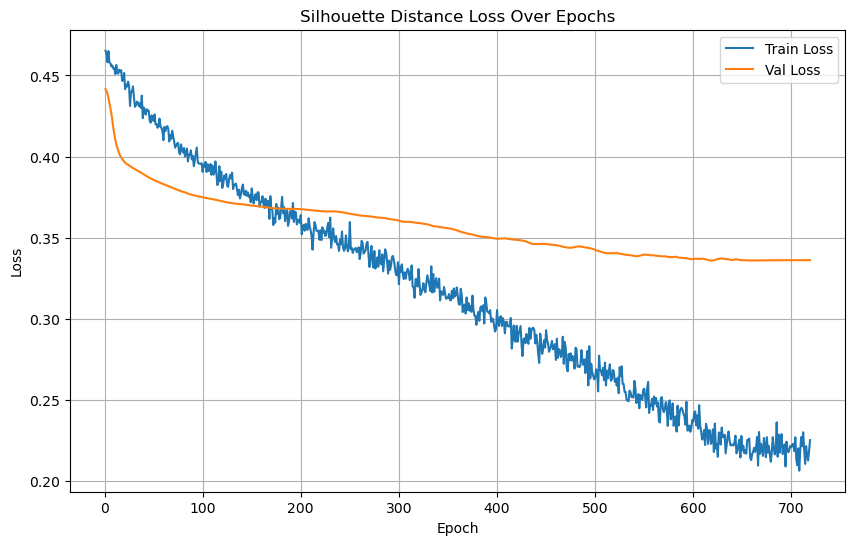

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.3129
Test Batch [20/667], Loss: 0.2337
Test Batch [30/667], Loss: 0.2932
Test Batch [40/667], Loss: 0.3576


Test Batch [50/667], Loss: 0.3245
Test Batch [60/667], Loss: 0.4587
Test Batch [70/667], Loss: 0.2901
Test Batch [80/667], Loss: 0.1567


Test Batch [90/667], Loss: 0.1080
Test Batch [100/667], Loss: 0.1935
Test Batch [110/667], Loss: 0.1524
Test Batch [120/667], Loss: 0.2525
Test Batch [130/667], Loss: 0.2805


Test Batch [140/667], Loss: 0.2498
Test Batch [150/667], Loss: 0.3129
Test Batch [160/667], Loss: 0.2169
Test Batch [170/667], Loss: 0.5000
Test Batch [180/667], Loss: 0.1733
Test Batch [190/667], Loss: 0.2209
Test Batch [200/667], Loss: 0.1996


Test Batch [210/667], Loss: 0.1750
Test Batch [220/667], Loss: 0.5000
Test Batch [230/667], Loss: 0.1833
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000
Test Batch [300/667], Loss: 0.5000
Test Batch [310/667], Loss: 0.3551
Test Batch [320/667], Loss: 0.2303


Test Batch [330/667], Loss: 0.2761
Test Batch [340/667], Loss: 0.2282
Test Batch [350/667], Loss: 0.1949


Test Batch [360/667], Loss: 0.2047
Test Batch [370/667], Loss: 0.2069
Test Batch [380/667], Loss: 0.2067


Test Batch [390/667], Loss: 0.1436
Test Batch [400/667], Loss: 0.1529
Test Batch [410/667], Loss: 0.2065


Test Batch [420/667], Loss: 0.2063
Test Batch [430/667], Loss: 0.2012
Test Batch [440/667], Loss: 0.4309


Test Batch [450/667], Loss: 0.2151
Test Batch [460/667], Loss: 0.4015
Test Batch [470/667], Loss: 0.4133


Test Batch [480/667], Loss: 0.3698
Test Batch [490/667], Loss: 0.3441
Test Batch [500/667], Loss: 0.3465


Test Batch [510/667], Loss: 0.1628
Test Batch [520/667], Loss: 0.2699
Test Batch [530/667], Loss: 0.3110
Test Batch [540/667], Loss: 0.2765


Test Batch [550/667], Loss: 0.3796
Test Batch [560/667], Loss: 0.2699
Test Batch [570/667], Loss: 0.2929
Test Batch [580/667], Loss: 0.2506


Test Batch [590/667], Loss: 0.2499
Test Batch [600/667], Loss: 0.4175
Test Batch [610/667], Loss: 0.3209
Test Batch [620/667], Loss: 0.3673


Test Batch [630/667], Loss: 0.3448
Test Batch [640/667], Loss: 0.2218
Test Batch [650/667], Loss: 0.3732


Test Batch [660/667], Loss: 0.4541

Test Loss: 0.3062


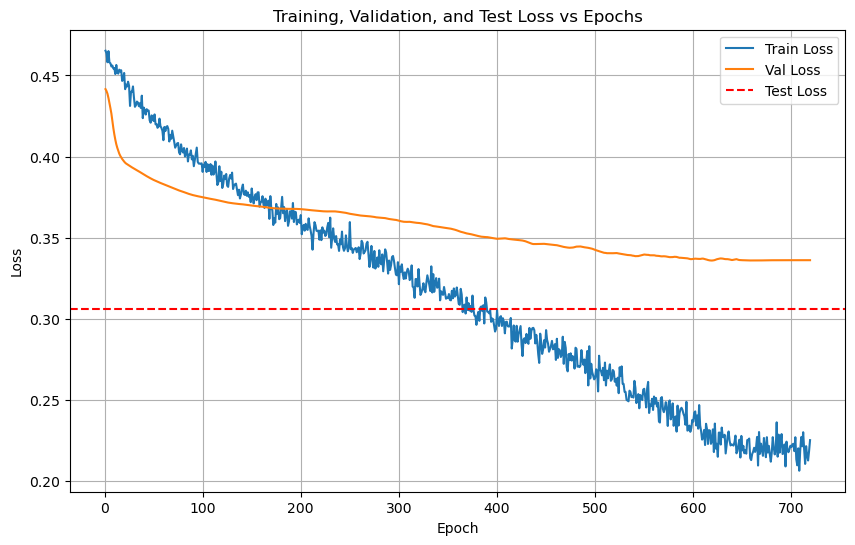

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/667 for test dataset.
  Processed batch 20/667 for test dataset.


  Processed batch 30/667 for test dataset.
  Processed batch 40/667 for test dataset.
  Processed batch 50/667 for test dataset.


  Processed batch 60/667 for test dataset.
  Processed batch 70/667 for test dataset.
  Processed batch 80/667 for test dataset.
  Processed batch 90/667 for test dataset.


  Processed batch 100/667 for test dataset.
  Processed batch 110/667 for test dataset.
  Processed batch 120/667 for test dataset.


  Processed batch 130/667 for test dataset.
  Processed batch 140/667 for test dataset.
  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.


  Processed batch 170/667 for test dataset.
  Processed batch 180/667 for test dataset.
  Processed batch 190/667 for test dataset.
  Processed batch 200/667 for test dataset.


  Processed batch 210/667 for test dataset.
  Processed batch 220/667 for test dataset.
  Processed batch 230/667 for test dataset.
  Processed batch 240/667 for test dataset.


  Processed batch 250/667 for test dataset.
  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.
  Processed batch 280/667 for test dataset.


  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.
  Processed batch 310/667 for test dataset.


  Processed batch 320/667 for test dataset.
  Processed batch 330/667 for test dataset.
  Processed batch 340/667 for test dataset.


  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.
  Processed batch 370/667 for test dataset.
  Processed batch 380/667 for test dataset.


  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.
  Processed batch 410/667 for test dataset.
  Processed batch 420/667 for test dataset.


  Processed batch 430/667 for test dataset.
  Processed batch 440/667 for test dataset.
  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.


  Processed batch 470/667 for test dataset.
  Processed batch 480/667 for test dataset.
  Processed batch 490/667 for test dataset.
  Processed batch 500/667 for test dataset.


  Processed batch 510/667 for test dataset.
  Processed batch 520/667 for test dataset.
  Processed batch 530/667 for test dataset.


  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.
  Processed batch 560/667 for test dataset.


  Processed batch 570/667 for test dataset.
  Processed batch 580/667 for test dataset.
  Processed batch 590/667 for test dataset.


  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.
  Processed batch 620/667 for test dataset.


  Processed batch 630/667 for test dataset.
  Processed batch 640/667 for test dataset.
  Processed batch 650/667 for test dataset.
  Processed batch 660/667 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       1.00      0.80      0.89         5
           2       0.50      0.40      0.44         5
           3       0.75      0.60      0.67         5
           4       1.00      1.00      1.00         5
           5       0.60      0.60      0.60         5
           6       0.56      1.00      0.71         5
           7       0.50      0.40      0.44         5
           8       1.00      1.00      1.00         5

    accuracy                           0.71        45
   macro avg       0.72      0.71      0.71        45
weighted avg       0.72      0.71      0.71        45


LOG: Evaluating on the test set...
Test Accuracy: 65.93%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42641, 128)
Test labels shape: (42641,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.0583  |  Val Loss: 2.0105
Validation loss improved from inf to 2.0105.
[Epoch 2/1000] Train Loss: 2.0230  |  Val Loss: 1.9819
Validation loss improved from 2.0105 to 1.9819.
[Epoch 3/1000] Train Loss: 1.9904  |  Val Loss: 1.9558
Validation loss improved from 1.9819 to 1.9558.
[Epoch 4/1000] Train Loss: 1.9609  |  Val Loss: 1.9314
Validation loss improved from 1.9558 to 1.9314.
[Epoch 5/1000] Train Loss: 1.9331  |  Val Loss: 1.9091
Validation loss improved from 1.9314 to 1.9091.
[Epoch 6/1000] Train Loss: 1.9077  |  Val Loss: 1.8880
Validation loss improved from 1.9091 to 1.8880.
[Epoch 7/1000] Train Loss: 1.8850  |  Val Loss: 1.8680
Validation loss improved from 1.8880 to 1.8680.
[Epoch 8/1000] Train Loss: 1.8597  |  Val Loss: 1.8489
Validation loss improved from 1.8680 to 1.8489.
[Epoch 9/1000] Train Loss: 1.8383  |  Val Loss: 1.8307
Validation loss improved from 1.8489 to 1.8307.
[Epoch 10/1000] Train Loss: 1.8169  |  Val Loss: 1.8135
Validation loss impr

[Epoch 38/1000] Train Loss: 1.4523  |  Val Loss: 1.5343
Validation loss improved from 1.5413 to 1.5343.


[Epoch 39/1000] Train Loss: 1.4428  |  Val Loss: 1.5275
Validation loss improved from 1.5343 to 1.5275.
[Epoch 40/1000] Train Loss: 1.4334  |  Val Loss: 1.5208
Validation loss improved from 1.5275 to 1.5208.
[Epoch 41/1000] Train Loss: 1.4239  |  Val Loss: 1.5143
Validation loss improved from 1.5208 to 1.5143.
[Epoch 42/1000] Train Loss: 1.4148  |  Val Loss: 1.5079
Validation loss improved from 1.5143 to 1.5079.
[Epoch 43/1000] Train Loss: 1.4049  |  Val Loss: 1.5017
Validation loss improved from 1.5079 to 1.5017.
[Epoch 44/1000] Train Loss: 1.3959  |  Val Loss: 1.4955
Validation loss improved from 1.5017 to 1.4955.
[Epoch 45/1000] Train Loss: 1.3868  |  Val Loss: 1.4894
Validation loss improved from 1.4955 to 1.4894.
[Epoch 46/1000] Train Loss: 1.3780  |  Val Loss: 1.4835
Validation loss improved from 1.4894 to 1.4835.
[Epoch 47/1000] Train Loss: 1.3690  |  Val Loss: 1.4776
Validation loss improved from 1.4835 to 1.4776.
[Epoch 48/1000] Train Loss: 1.3602  |  Val Loss: 1.4717
Validati

[Epoch 85/1000] Train Loss: 1.0574  |  Val Loss: 1.2736
Validation loss improved from 1.2790 to 1.2736.
[Epoch 86/1000] Train Loss: 1.0492  |  Val Loss: 1.2683
Validation loss improved from 1.2736 to 1.2683.
[Epoch 87/1000] Train Loss: 1.0410  |  Val Loss: 1.2630
Validation loss improved from 1.2683 to 1.2630.
[Epoch 88/1000] Train Loss: 1.0328  |  Val Loss: 1.2577
Validation loss improved from 1.2630 to 1.2577.
[Epoch 89/1000] Train Loss: 1.0247  |  Val Loss: 1.2524
Validation loss improved from 1.2577 to 1.2524.
[Epoch 90/1000] Train Loss: 1.0165  |  Val Loss: 1.2472
Validation loss improved from 1.2524 to 1.2472.
[Epoch 91/1000] Train Loss: 1.0082  |  Val Loss: 1.2420
Validation loss improved from 1.2472 to 1.2420.
[Epoch 92/1000] Train Loss: 0.9997  |  Val Loss: 1.2367
Validation loss improved from 1.2420 to 1.2367.
[Epoch 93/1000] Train Loss: 0.9919  |  Val Loss: 1.2314
Validation loss improved from 1.2367 to 1.2314.
[Epoch 94/1000] Train Loss: 0.9833  |  Val Loss: 1.2262
Validati

[Epoch 130/1000] Train Loss: 0.6955  |  Val Loss: 1.0499
Validation loss improved from 1.0543 to 1.0499.
[Epoch 131/1000] Train Loss: 0.6881  |  Val Loss: 1.0454
Validation loss improved from 1.0499 to 1.0454.
[Epoch 132/1000] Train Loss: 0.6807  |  Val Loss: 1.0410
Validation loss improved from 1.0454 to 1.0410.
[Epoch 133/1000] Train Loss: 0.6735  |  Val Loss: 1.0366
Validation loss improved from 1.0410 to 1.0366.
[Epoch 134/1000] Train Loss: 0.6660  |  Val Loss: 1.0322
Validation loss improved from 1.0366 to 1.0322.
[Epoch 135/1000] Train Loss: 0.6589  |  Val Loss: 1.0279
Validation loss improved from 1.0322 to 1.0279.
[Epoch 136/1000] Train Loss: 0.6515  |  Val Loss: 1.0236
Validation loss improved from 1.0279 to 1.0236.
[Epoch 137/1000] Train Loss: 0.6445  |  Val Loss: 1.0193
Validation loss improved from 1.0236 to 1.0193.
[Epoch 138/1000] Train Loss: 0.6372  |  Val Loss: 1.0149
Validation loss improved from 1.0193 to 1.0149.
[Epoch 139/1000] Train Loss: 0.6302  |  Val Loss: 1.010

[Epoch 169/1000] Train Loss: 0.4398  |  Val Loss: 0.9135
Validation loss improved from 0.9158 to 0.9135.
[Epoch 170/1000] Train Loss: 0.4341  |  Val Loss: 0.9111
Validation loss improved from 0.9135 to 0.9111.
[Epoch 171/1000] Train Loss: 0.4290  |  Val Loss: 0.9089
Validation loss improved from 0.9111 to 0.9089.
[Epoch 172/1000] Train Loss: 0.4235  |  Val Loss: 0.9067
Validation loss improved from 0.9089 to 0.9067.
[Epoch 173/1000] Train Loss: 0.4183  |  Val Loss: 0.9045
Validation loss improved from 0.9067 to 0.9045.
[Epoch 174/1000] Train Loss: 0.4133  |  Val Loss: 0.9024
Validation loss improved from 0.9045 to 0.9024.
[Epoch 175/1000] Train Loss: 0.4081  |  Val Loss: 0.9000
Validation loss improved from 0.9024 to 0.9000.
[Epoch 176/1000] Train Loss: 0.4033  |  Val Loss: 0.8978
Validation loss improved from 0.9000 to 0.8978.
[Epoch 177/1000] Train Loss: 0.3983  |  Val Loss: 0.8956
Validation loss improved from 0.8978 to 0.8956.
[Epoch 178/1000] Train Loss: 0.3934  |  Val Loss: 0.893

[Epoch 216/1000] Train Loss: 0.2503  |  Val Loss: 0.8483
Validation loss improved from 0.8489 to 0.8483.
[Epoch 217/1000] Train Loss: 0.2474  |  Val Loss: 0.8477
Validation loss improved from 0.8483 to 0.8477.
[Epoch 218/1000] Train Loss: 0.2444  |  Val Loss: 0.8473
Validation loss improved from 0.8477 to 0.8473.
[Epoch 219/1000] Train Loss: 0.2418  |  Val Loss: 0.8466
Validation loss improved from 0.8473 to 0.8466.
[Epoch 220/1000] Train Loss: 0.2391  |  Val Loss: 0.8459
Validation loss improved from 0.8466 to 0.8459.
[Epoch 221/1000] Train Loss: 0.2364  |  Val Loss: 0.8455
Validation loss improved from 0.8459 to 0.8455.
[Epoch 222/1000] Train Loss: 0.2338  |  Val Loss: 0.8452
Validation loss improved from 0.8455 to 0.8452.
[Epoch 223/1000] Train Loss: 0.2312  |  Val Loss: 0.8451
Validation loss improved from 0.8452 to 0.8451.
[Epoch 224/1000] Train Loss: 0.2286  |  Val Loss: 0.8451
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 225/1000] Train Loss: 0.2260  |  Val Loss:

[Epoch 261/1000] Train Loss: 0.1556  |  Val Loss: 0.8437
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 262/1000] Train Loss: 0.1541  |  Val Loss: 0.8436
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 263/1000] Train Loss: 0.1527  |  Val Loss: 0.8437
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 264/1000] Train Loss: 0.1512  |  Val Loss: 0.8439
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 265/1000] Train Loss: 0.1498  |  Val Loss: 0.8441
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 266/1000] Train Loss: 0.1483  |  Val Loss: 0.8445
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 267/1000] Train Loss: 0.1470  |  Val Loss: 0.8452
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 268/1000] Train Loss: 0.1456  |  Val Loss: 0.8459
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 269/1000] Train Loss: 0.1442  |  Val Loss: 0.8467
!! Validation loss did NOT improve !! Patience:

[Epoch 310/1000] Train Loss: 0.0990  |  Val Loss: 0.8706
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 311/1000] Train Loss: 0.0981  |  Val Loss: 0.8717
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 312/1000] Train Loss: 0.0973  |  Val Loss: 0.8727
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 313/1000] Train Loss: 0.0965  |  Val Loss: 0.8736
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 314/1000] Train Loss: 0.0956  |  Val Loss: 0.8746
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 315/1000] Train Loss: 0.0948  |  Val Loss: 0.8756
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 316/1000] Train Loss: 0.0940  |  Val Loss: 0.8769
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 317/1000] Train Loss: 0.0933  |  Val Loss: 0.8783
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 318/1000] Train Loss: 0.0925  |  Val Loss: 0.8796
!! Validation loss did NOT improve !! Patience:

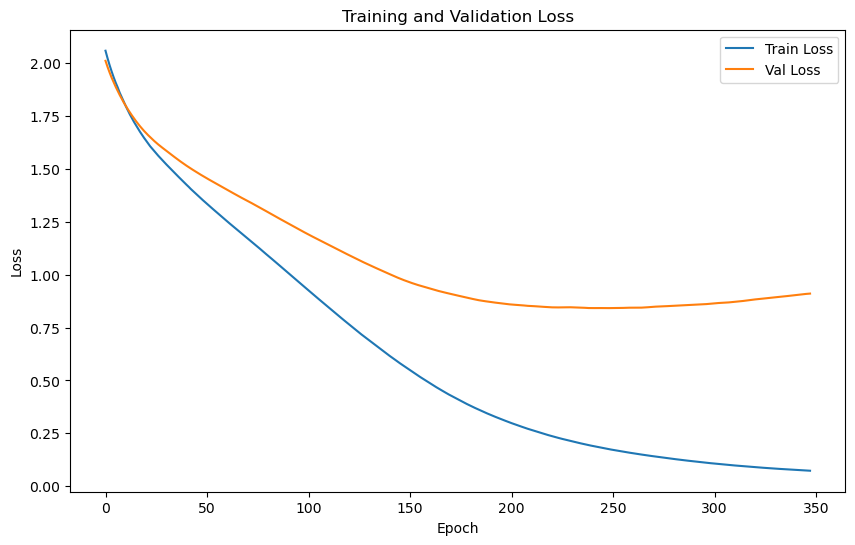

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.5102 | Test Accuracy: 64.22%


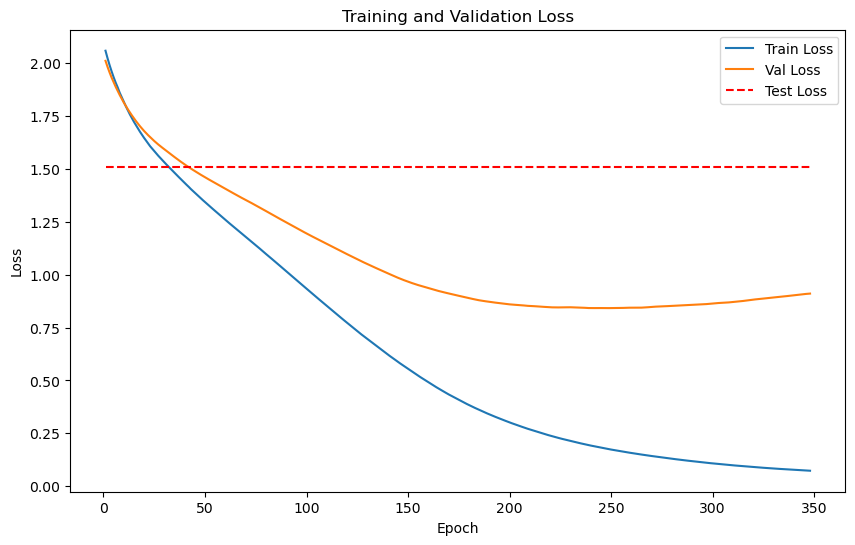

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


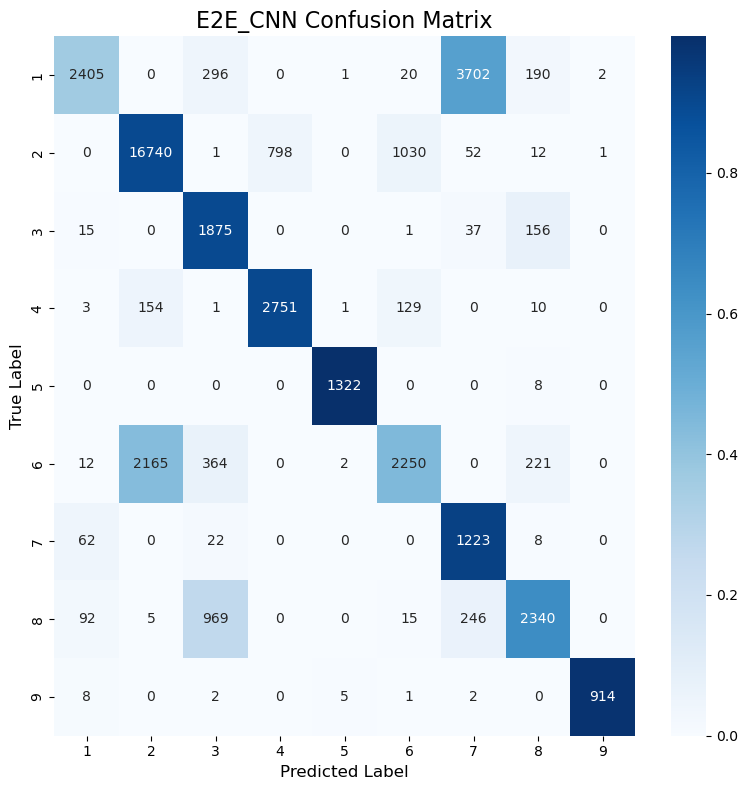

Classification Accuracy: 74.62%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


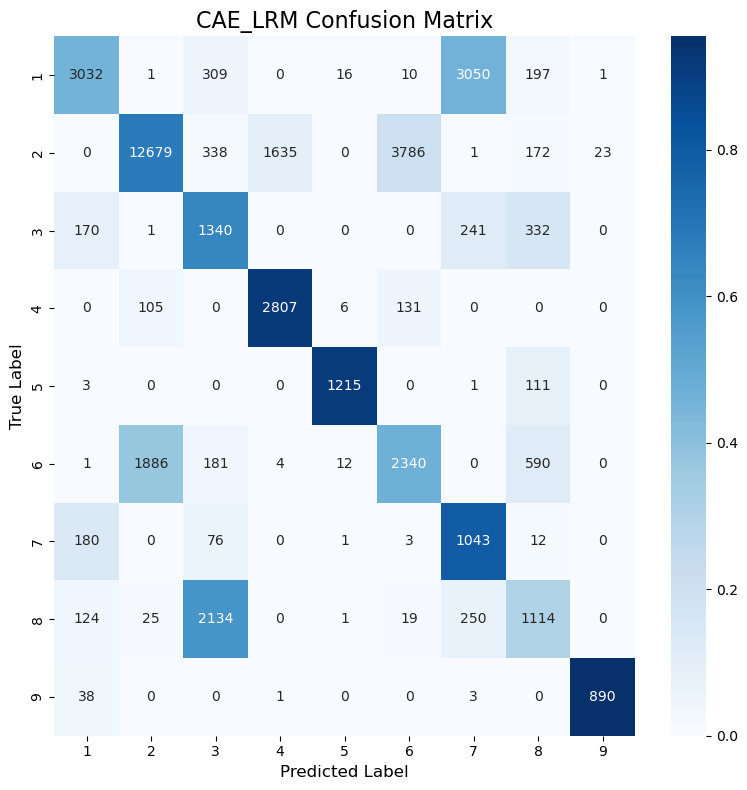

Classification Accuracy: 62.05%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


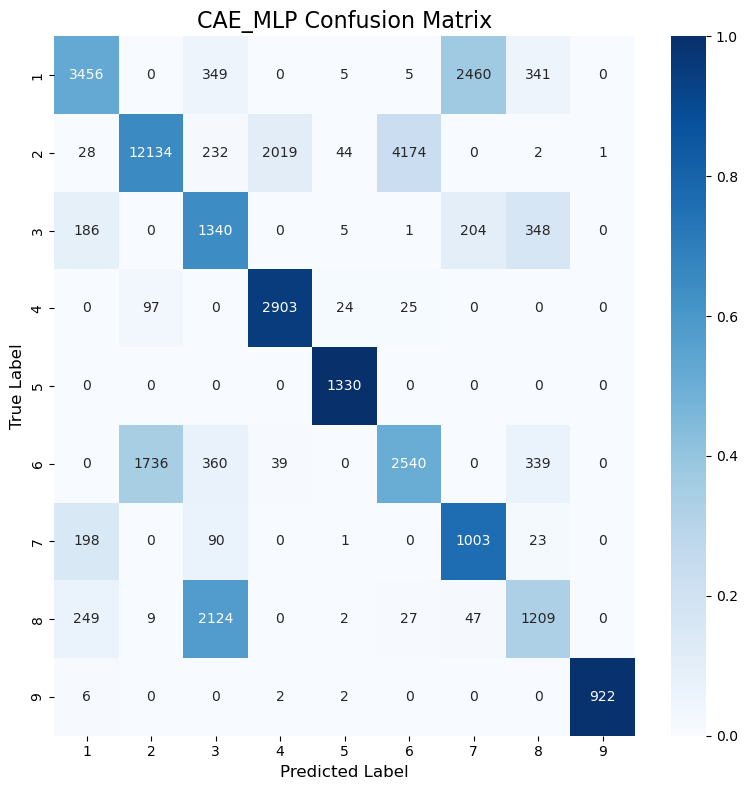

Classification Accuracy: 62.94%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


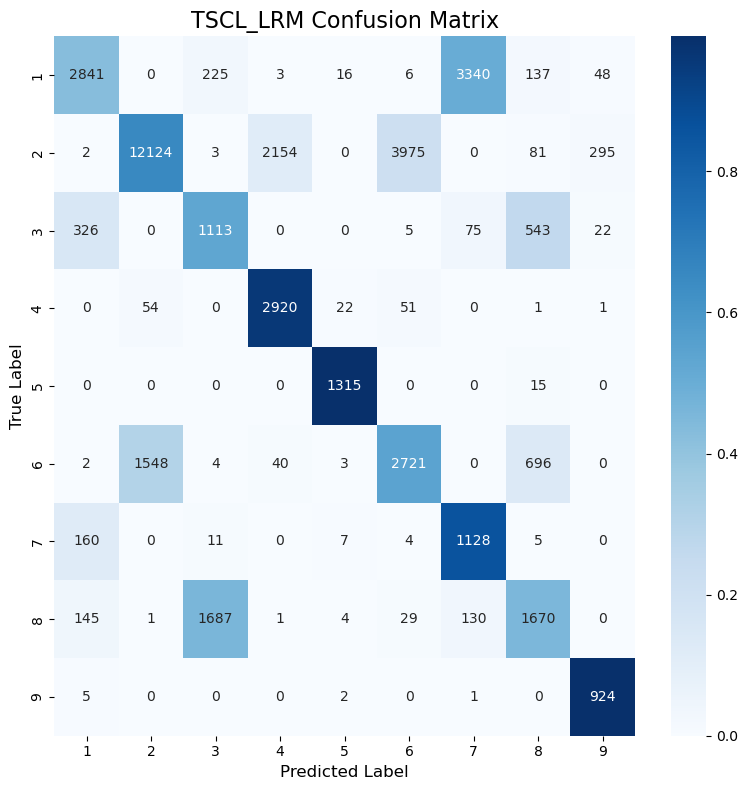

Classification Accuracy: 62.75%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


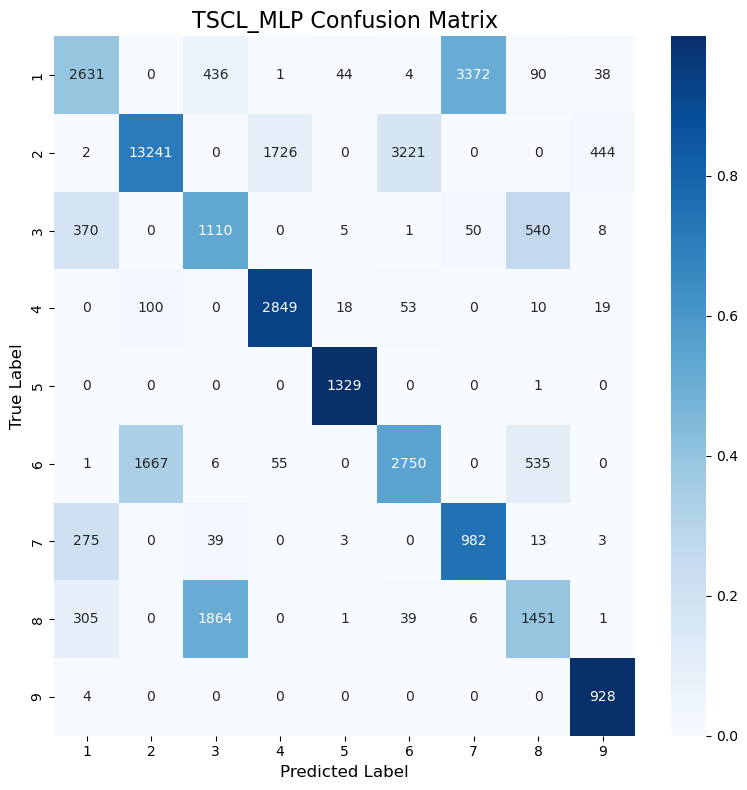

Classification Accuracy: 63.95%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


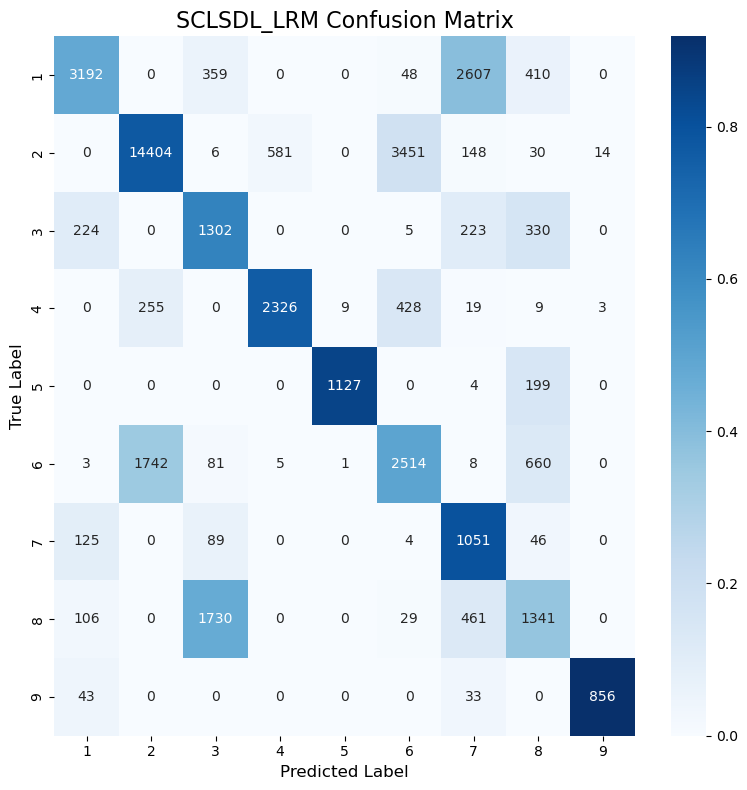

Classification Accuracy: 65.93%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


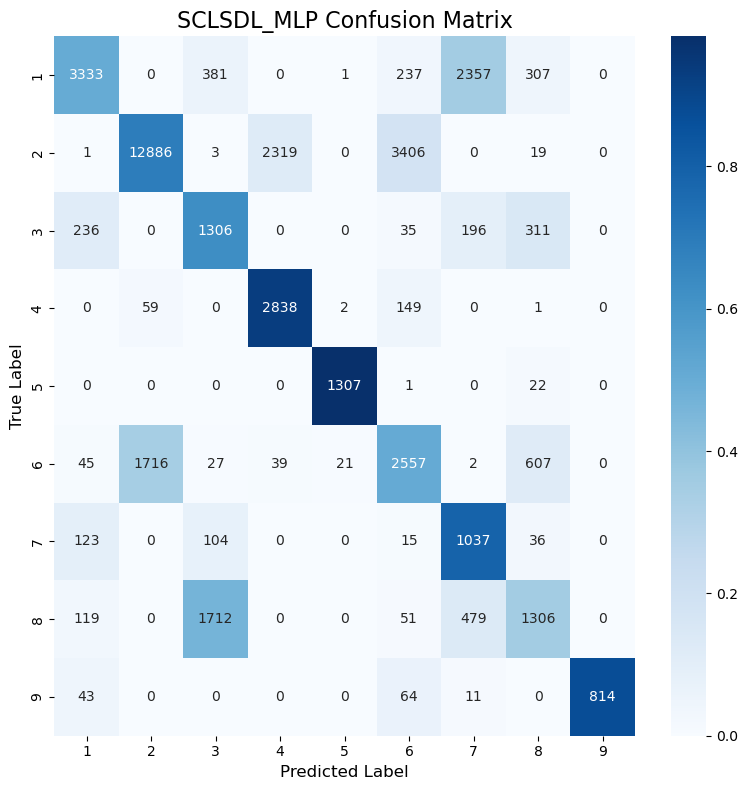

Classification Accuracy: 64.22%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          74.62
1    LRM (CAE)          62.05
2    MLP (CAE)          62.94
3     TSCL LRM          62.75
4     TSCL MLP          63.95
5  SCL_SDL LRM          65.93
6  SCL_SDL MLP          64.22

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          74.62
5  SCL_SDL LRM          65.93
6  SCL_SDL MLP          64.22
4     TSCL MLP          63.95
2    MLP (CAE)          62.94
3     TSCL LRM          62.75
1    LRM (CAE)          62.05
